# 5회차: ANOVA, 상관분석, A/B 테스트

## 목차

| 순서 | 파트   | 주제                     | 핵심 내용                                                |
|------|--------|--------------------------|----------------------------------------------------------|
| 1    | Part 1 | 분산분석 (ANOVA)         | One-way ANOVA, Welch's ANOVA, Kruskal-Wallis, 사후검정, 효과크기 |
| 2    | Part 2 | 상관분석                 | Pearson, Spearman, 산점도, 히트맵, 가설검정, 상관 vs 인과 |
| 3    | Part 3 | A/B 테스트               | 실험 설계, 표본 크기 산정, 검정력 분석, 전환율 비교       |

> **실습 과제**는 별도 파일 `practice_05_assignment.ipynb`에 있습니다.

## Part 1: 분산분석 (ANOVA)

### 1.1 주요 용어 정리

| 용어              | 영어                            | 정의                                                       |
|-------------------|---------------------------------|------------------------------------------------------------|
| 분산분석          | Analysis of Variance (ANOVA)    | 3개 이상 집단의 평균 차이를 검정하는 방법                   |
| 일원분산분석      | One-way ANOVA                   | 하나의 독립변수(요인)에 대해 3개 이상 집단의 평균을 비교    |
| Welch's ANOVA     | Welch's ANOVA                   | 등분산 가정이 위반될 때 사용하는 분산분석                   |
| Kruskal-Wallis    | Kruskal-Wallis H Test           | ANOVA의 비모수 대안 — 정규성 위반 시 순위 기반 검정         |
| 사후검정          | Post-hoc Test                   | ANOVA에서 유의한 결과 후, 어떤 집단 쌍이 다른지 확인        |
| Tukey HSD         | Tukey's Honestly Significant Difference | One-way ANOVA의 대표적 사후검정 — 모든 쌍 비교    |
| Games-Howell      | Games-Howell Test               | 등분산 위반 시(Welch's ANOVA 후) 사후검정                   |
| Dunn 검정         | Dunn's Test                     | Kruskal-Wallis 후 비모수 사후검정                           |

In [2]:
# ── 필수 라이브러리 Import ──
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
import pingouin as pg
import scikit_posthocs as sp
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, proportion_confint
from statsmodels.stats.power import NormalIndPower
import warnings
import platform

warnings.filterwarnings('ignore')

# ── 운영체제별 한글 폰트 설정 ──
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 전역 시드 설정 (재현성을 위해)
np.random.seed(42)

print("=" * 60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("=" * 60)

라이브러리 로드 완료!
한글 폰트 설정 완료!


In [ ]:
# ---------------------------------------------------------------------------
# ModuleNotFoundError                       Traceback (most recent call last)
# Cell In[1], line 9
#       7 from itertools import combinations
#       8 import pingouin as pg
# ----> 9 import scikit_posthocs as sp
#      10 from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, proportion_confint
#      11 from statsmodels.stats.power import NormalIndPower

# ModuleNotFoundError: No module named 'scikit_posthocs'

# uv add scikit_posthocs
# uv add를 하면 환경 관리 --> 패키지 관리!

### 1.2 ANOVA란?

**ANOVA(Analysis of Variance)** 는 **3개 이상 집단의 평균**이 모두 같은지 검정하는 방법입니다.

- **귀무가설(H₀)**: 모든 집단의 평균이 같다 (μ₁ = μ₂ = μ₃ = ...)

- **대립가설(H₁)**: 적어도 하나의 집단 평균이 다르다

> **t-검정을 여러 번 하면 안 되나요?** \
> 3집단을 t-검정으로 비교하면 3번 검정(A-B, A-C, B-C)이 필요합니다. \
> 각 검정마다 α=0.05의 오류 확률이 있으므로, 전체 1종 오류율은 $1 - (1-0.05)^3 ≈ 0.143$ (14.3%)로 급격히 증가합니다. \
> ANOVA는 **한 번의 검정**으로 전체 집단을 비교하여 이 문제를 해결합니다.

### 1.3 ANOVA의 원리 — 집단 간 변동 vs 집단 내 변동

ANOVA는 **전체 변동(SS_T)** 을 두 가지로 분해합니다.

$$SS_T = SS_B + SS_W$$

| 변동           | 영어 표기 | 공식                                    | 의미                                    |
|:--------------:|:----------|:---------------------------------------:|-----------------------------------------|
| **SS_B** (집단 간 제곱합) | Sum of Squares Between | $\sum n_j (\bar{X}_j - \bar{X})^2$  | 각 집단 평균이 전체 평균에서 떨어진 정도 (집단 효과) |
| **SS_W** (집단 내 제곱합) | Sum of Squares Within | $\sum \sum (X_{ij} - \bar{X}_j)^2$  | 각 관측값이 자기 집단 평균에서 떨어진 정도 (오차) |
| **df_B** (집단 간 자유도) | Degrees of Freedom Between | $k - 1$                                | 집단 수 − 1 |
| **df_W** (집단 내 자유도) | Degrees of Freedom Within | $N - k$                                | 전체 표본 크기 − 집단 수 |
| **MS_B** (집단 간 평균제곱) | Mean Square Between | $\frac{SS_B}{df_B} = \frac{SS_B}{k-1}$ | 집단 간 변동의 평균 (집단 효과의 크기) |
| **MS_W** (집단 내 평균제곱) | Mean Square Within | $\frac{SS_W}{df_W} = \frac{SS_W}{N-k}$ | 집단 내 변동의 평균 (오차의 크기) |
| **F 통계량** | F-statistic | $F = \frac{MS_B}{MS_W}$ | 집단 간 변동 / 집단 내 변동 (신호/잡음 비율) |

> **F 통계량 해석**:
> - **F가 크다** → 집단 간 차이가 집단 내 변동(오차)보다 훨씬 크다 → 집단 효과 존재 가능성 높음
> - **F가 작다** → 집단 간 차이가 오차 수준에 불과 → 집단 효과 없음

---

#### SS_B 공식에서 왜 집단 크기 $n_j$를 곱할까요?

**집단 크기에 따른 가중치**
 - 100명 집단의 편차 > 5명 집단의 편차 (영향력)
 - 큰 집단의 평균 편차가 전체 변동에 더 큰 영향을 미칩니다

**결론**: $n_j$는 각 집단의 **가중치**이며, 집단 크기가 클수록 전체 변동에 더 큰 영향을 미칩니다.

<img src="images/pr_05/ANOVA_변동분해.png" width="100%">

### 1.4 검정 방법 선택 가이드 (독립 3집단+)

| 정규성 확인             | 등분산 확인 | 검정 방법              | 사후검정               | 효과크기                        |
|:------------------------:|:-----------:|:----------------------:|:----------------------:|:-------------------------------:|
| Q-Q Plot + Shapiro-Wilk | Levene      | One-way ANOVA          | Tukey HSD              | η² / ω²                        |
| Q-Q Plot + Shapiro-Wilk | Levene (위반) | Welch's ANOVA        | Games-Howell           | η² / ω²                        |
| 정규성 위반              | —           | Kruskal-Wallis         | Dunn 검정              | η²_H                           |

> **정규성 위반 시** 비모수 검정(Kruskal-Wallis)을 사용하며, 이 경우 등분산 확인은 불필요합니다.
>
> **등분산성 위반은 CLT와 무관합니다** — 정규성은 대표본에서 CLT로 완화되지만, 등분산성은 표본 크기와 관계없이 Levene 위반 시 항상 Welch's ANOVA를 사용합니다.

---

> ### ⚠️ 대표본과 정규성 — 반드시 알아야 할 개념 (중심극한정리, CLT)
>
> **핵심**: t-검정, ANOVA 등 **평균을 비교하는 모든 모수적 검정**은
> 표본 크기가 충분히 크면, **원래 데이터가 정규분포가 아니더라도 사용할 수 있습니다.**
>
> #### 왜 그런가요?
>
> | 구분 | Shapiro-Wilk / Q-Q Plot | t-검정 / ANOVA (F 검정) |
> |------|------------------------|------------------------|
> | **검정 대상** | 원래 데이터의 분포 | **표본평균**의 분포 |
> | **정규성 필요 대상** | 개별 관측값 | 집단 평균 |
>
> - Shapiro-Wilk, Q-Q Plot은 **개별 데이터**가 정규분포인지 검정합니다
> - 그러나 t-검정과 ANOVA는 **집단 평균**을 비교하는 것입니다
> - **중심극한정리(CLT)**: 표본 크기가 충분하면, 원래 분포와 관계없이
>   **표본평균의 분포**가 정규분포에 근사합니다
> - 따라서 **Shapiro-Wilk가 기각되더라도** 표본이 크면 t-검정/ANOVA는 유효합니다
>
> #### 원래 분포에 따라 필요한 표본 크기가 다릅니다
>
> CLT는 "언젠가 수렴한다"는 정리이지, "n ≥ 30이면 항상 충분하다"는 보장이 아닙니다.
> **원래 분포가 정규분포에서 멀수록, CLT가 작동하기 위해 더 큰 n이 필요합니다.**
>
> | 원래 분포 형태 | 예시 | CLT 충분한 n | 이유 |
> |:--------------:|:----:|:------------:|:-----|
> | 대칭 + 가벼운 꼬리 | 균등분포 | **n ≥ 10~15** | 이미 대칭이라 평균 분포가 빠르게 수렴 |
> | 약한 비대칭 | 약간 치우친 연속분포 | **n ≥ 15~20** | 왜도가 작아 수렴이 빠름 |
> | 중간 비대칭 | 지수분포, 포아송 | **n ≥ 30** | 통상적 기준 (대부분의 교재 권장) |
> | 강한 비대칭 | 로그정규, 파레토 | **n ≥ 100~200+** | 긴 꼬리(heavy tail)가 평균을 불안정하게 만듦 |
> | 이봉분포 / 극단적 이상치 | 혼합분포 | **비모수 검정 권장** | 아래 참고 |
>
> > ※ 위 표의 n 기준은 **각 집단별** 표본 크기이며, **t-검정과 ANOVA 모두** 동일하게 적용됩니다.
> > 로그정규(σ ≥ 2)나 파레토(α ≈ 2) 같은 극단적 분포는 n = 1,000에서도 수렴이 불충분할 수 있습니다
> > (Akinshin, 2023; Salazar, 2020). 이런 경우 비모수 검정이 더 안전합니다.
>
> > **⚠️ "이상치가 많으면 비모수" — 왜?**
> > 이상치가 많은 경우, CLT 자체는 대표본에서 여전히 작동합니다 (표본평균의 분포는 정규에 수렴).
> > 문제는 **평균이라는 통계량 자체의 대표성**입니다.
> > 이상치가 많으면 평균이 데이터의 중심을 제대로 반영하지 못하므로,
> > 평균을 비교하는 t-검정/ANOVA의 결과 자체가 의미를 잃습니다.
> > 비모수 검정(Mann-Whitney, Kruskal-Wallis)은 **중앙값/순위** 기반이라 이상치에 강건(robust)합니다.
>
> #### 객관적 판단 근거: 왜도(skewness)
>
> CLT 수렴 속도를 결정하는 핵심 요인은 **왜도(skewness)** 입니다 (Berry-Esseen 정리).
> 왜도 분류 기준은 **Bulmer(1979)** *Principles of Statistics* 에서 유래합니다.
>
> ```python
> from scipy.stats import skew
> print(f"왜도: {skew(data):.2f}")  # 0에 가까울수록 대칭
> ```
>
> | \|skew\| | 분류 (Bulmer, 1979) | CLT 실무 기준 |
> |:--------:|:-------------------:|:-------------|
> | < 0.5 | 거의 대칭 | n ≥ 15~20이면 충분 |
> | 0.5 ~ 1.0 | 중간 비대칭 | n ≥ 30 권장 |
> | > 1.0 | 강한 비대칭 | **n ≥ 100+ 또는 비모수 고려** |
>
> > ※ CLT 표본 크기 기준은 OpenIntro Statistics(Diez et al.), Moore/McCabe 등
> > 주요 교재의 권장 사항을 종합한 것입니다. Smith & Wells(2006) 시뮬레이션에 따르면
> > \|skew\| > 1.0인 분포는 n = 175에서도 수렴이 불안정할 수 있습니다.
>
> #### 보조 지표: 첨도(kurtosis)
>
> 첨도는 CLT 수렴 속도의 **주요 요인은 아니지만**(Berry-Esseen 정리는 왜도 기반),
> 꼬리 두께를 나타내므로 **이상치 빈도를 간접적으로** 파악하는 데 유용합니다.
>
> ```python
> from scipy.stats import kurtosis
> print(f"초과첨도: {kurtosis(data):.2f}")  # 0이면 정규분포와 유사한 꼬리
> ```
>
> - scipy의 `kurtosis()`는 **초과첨도**(excess kurtosis)를 반환합니다 (정규분포 = 0)
> - 초과첨도 > 2~3 → 꼬리가 두꺼움 → 이상치 빈도 증가 → 평균 불안정
> - 초과첨도 > 7 → 극단적 (West, Finch & Curran, 1996) → 비모수 고려
> - **주의**: 첨도만으로 CLT 적용 여부를 판단하지 말고, 왜도 + Q-Q Plot과 함께 종합 판단
>
> > **실무 요약**: Q-Q Plot으로 분포 형태를 눈으로 확인하고,
> > `skew()`와 `kurtosis()`로 수치를 확인한 뒤, 위 기준과 표본 크기를 함께 고려하여 판단합니다.
>
> #### Shapiro-Wilk의 역설
>
> 역설적으로, **대표본(n > 100)에서는 Shapiro-Wilk가 너무 민감**해집니다.
> 실무적으로 무의미한 아주 미세한 비정규성까지 탐지하여 거의 모든 실제 데이터를 기각합니다.
> 따라서 대표본에서 Shapiro-Wilk p < 0.05라는 결과만으로 비모수 검정으로 전환하는 것은
> 오히려 **검정력(power)을 낭비**하는 결과를 낳을 수 있습니다.
>
> **결론**: 정규성 검정 결과는 표본 크기와 함께 해석해야 합니다.
> 소표본에서 기각 → 비모수 검정 | 대표본에서 기각 → Q-Q Plot으로 분포 형태를 확인 후 판단
> **본 교안의 전략**: 학습 목적으로 소표본(n=20~30) 시나리오를 다루므로,
> Shapiro-Wilk 기각 시 Kruskal-Wallis로 분기하는 **보수적 전략**을 따릅니다.
> 실무에서 대표본을 다룰 때는 위 기준을 참고하여 유연하게 판단하시기 바랍니다.

### 1.5 효과크기 정리 (3집단+)

| 효과크기 | 적용 검정 | 공식 | 공식 의미 | Python 코드 | 해석 기준 (small / medium / large) |
|----------|----------|------|----------|-------------|--------------------------------------|
| **η²** (에타제곱) | One-way ANOVA | SS_B / SS_T | 전체 변동 중 **집단 간 차이가 설명하는 비율** (0~1) | `pg.anova(dv, between, data)['np2']` | 0.01 / 0.06 / 0.14 |
| **ω²** (오메가제곱) | One-way ANOVA | (SS_B − df_B · MS_W) / (SS_T + MS_W) | η²의 **편향 보정 버전** (0~1) | 수동 계산 | 0.01 / 0.06 / 0.14 |
| **η²_H** | Kruskal-Wallis | (H − k + 1) / (N − k) | η²의 **비모수 버전** — 순위 기반 (0~1) | 수동 계산 | η²와 동일 기준 적용 |

> **실무 팁**: 3집단+ 비교에서는 전체 효과크기(η²)보다 **사후검정의 쌍별 효과크기**가 실질적으로 더 중요합니다.

#### 사후검정별 쌍별 효과크기

| 검정 경로 | 사후검정 | 쌍별 효과크기 | 해석 기준 |
|-----------|---------|-------------|----------|
| ANOVA + Tukey | Tukey HSD | **Cohen's d** | 0.2 / 0.5 / 0.8 |
| Welch's + Games-Howell | Games-Howell | **Hedges' g** | 동일 (Cohen's d의 소표본 보정) |
| Kruskal-Wallis + Dunn | Dunn | 없음 (η²_H만 보고) | 평균 기반 d가 부적절 |

> **Kruskal-Wallis**는 평균의 대표성이 낮아 비모수를 선택한 것이므로,
> 평균 기반인 Cohen's d를 계산하는 것은 모순입니다. 대신:
> - **전체 효과**: η²_H로 보고
> - **쌍별 비교**: Dunn 검정 p-value + **중앙값 차이**로 방향과 크기를 해석

#### Cohen's d / Hedges' g 공식

$$d = \frac{\bar{x}_1 - \bar{x}_2}{\sigma_{pooled}}, \quad \sigma_{pooled} = \sqrt{\frac{s_1^2 + s_2^2}{2}}$$

- $\bar{x}_1, \bar{x}_2$: 두 집단의 평균, $s_1, s_2$: 두 집단의 표준편차, $n_1, n_2$: 두 집단의 표본 크기
- **Hedges' g** = Cohen's d × J, $\quad J = 1 - \frac{3}{4(n_1+n_2-2)-1}$ (소표본 편향 제거, 대표본에서는 d ≈ g)

| \|d\| 또는 \|g\| | 해석 (Cohen, 1988) |
|:---:|:---|
| < 0.2 | 매우 작은 효과 (실질적 차이 거의 없음) |
| 0.2 ~ 0.5 | 작은 효과 |
| 0.5 ~ 0.8 | 중간 효과 |
| ≥ 0.8 | 큰 효과 |

> **η²는 "전체적으로 차이가 있는가?"**, **Cohen's d / Hedges' g는 "어떤 쌍이 얼마나 다른가?"** 를 답합니다.
> 논문 작성 시 두 지표를 모두 보고하되, **쌍별 효과크기를 중심으로 결과를 해석**하는 것이 권장됩니다.

### 시나리오 1: One-way ANOVA — 교육 방법별 시험 점수 비교

**상황**: 한 교육기관에서 3가지 교육 방법(강의식, 토론식, 실습식)의 효과를 비교하기 위해

각 방법으로 학습한 학생들의 시험 점수를 비교합니다.

- **귀무가설(H₀)**: 세 교육 방법의 평균 점수가 모두 같다

- **대립가설(H₁)**: 적어도 하나의 교육 방법의 평균 점수가 다르다

In [4]:
# ── 시나리오 1: 데이터 생성 ──
print("[시나리오 1] One-way ANOVA — 교육 방법별 시험 점수 비교")
print("=" * 60)

np.random.seed(100)
lecture = np.round(np.random.normal(72, 8, 25), 1)     # 강의식
discussion = np.round(np.random.normal(78, 7, 25), 1)  # 토론식
practice = np.round(np.random.normal(82, 9, 25), 1)    # 실습식

groups = ['강의식'] * 25 + ['토론식'] * 25 + ['실습식'] * 25
scores = np.concatenate([lecture, discussion, practice])
df_anova = pd.DataFrame({'교육방법': groups, '점수': scores})

print(f"\n  각 집단 표본 크기: {len(lecture)}명")
for name, data in [('강의식', lecture), ('토론식', discussion), ('실습식', practice)]:
    print(f"  {name}: 평균={data.mean():.1f}, 표준편차={data.std(ddof=1):.1f}")

[시나리오 1] One-way ANOVA — 교육 방법별 시험 점수 비교

  각 집단 표본 크기: 25명
  강의식: 평균=72.7, 표준편차=6.8
  토론식: 평균=76.8, 표준편차=7.3
  실습식: 평균=79.7, 표준편차=8.6


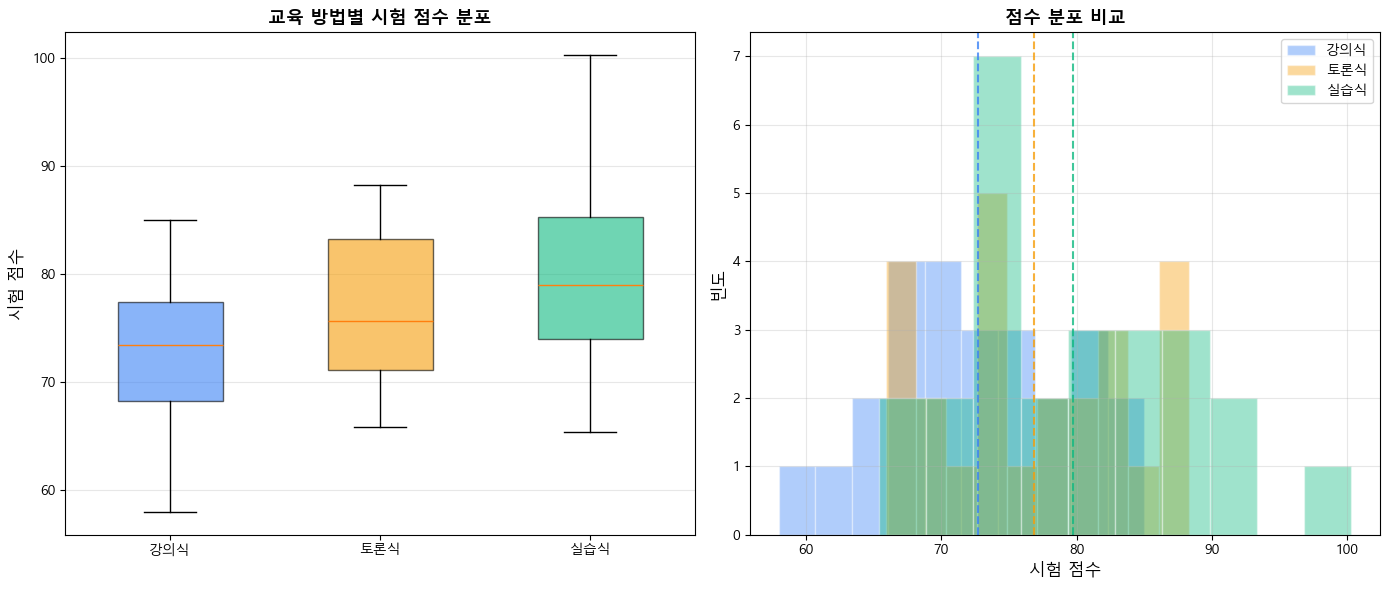

In [5]:
# ── 분포 시각화 (박스플롯 + 개별 데이터) ──
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 박스플롯
colors = ['#3B82F6', '#F59E0B', '#10B981']
bp = axes[0].boxplot([lecture, discussion, practice],
                      labels=['강의식', '토론식', '실습식'],
                      patch_artist=True, widths=0.5)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[0].set_ylabel('시험 점수', fontsize=12)
axes[0].set_title('교육 방법별 시험 점수 분포', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 히스토그램 겹치기
for data, name, color in [(lecture, '강의식', '#3B82F6'),
                           (discussion, '토론식', '#F59E0B'),
                           (practice, '실습식', '#10B981')]:
    axes[1].hist(data, bins=10, alpha=0.4, color=color, edgecolor='white', label=name)
    axes[1].axvline(data.mean(), color=color, linestyle='--', alpha=0.8)

axes[1].set_xlabel('시험 점수', fontsize=12)
axes[1].set_ylabel('빈도', fontsize=12)
axes[1].set_title('점수 분포 비교', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### 1단계: 가정 검정 (정규성 + 등분산)

In [6]:
# ── 1단계-A: Shapiro-Wilk 정규성 검정 ──
print("[1단계-A] Shapiro-Wilk 정규성 검정 (각 집단)")
print("=" * 60)

normality_ok = True
for name, data in [('강의식', lecture), ('토론식', discussion), ('실습식', practice)]:
    # TODO: Shapiro-Wilk 정규성 검정 수행 (stats.shapiro)
    stat_sw, p_sw = stats.shapiro(data)

    result = "정규성 유지" if (p_sw is not None and p_sw > 0.05) else "정규성 위반"
    if p_sw is not None and p_sw <= 0.05:
        normality_ok = False
    stat_viz = stat_sw if stat_sw is not None else 0
    p_viz = p_sw if p_sw is not None else 0
    print(f"  {name}: W={stat_viz:.4f}, p={p_viz:.4f} ({result})")

if normality_ok:
    print("\n  모든 집단이 정규분포를 따르므로 등분산 검정으로 진행합니다")
else:
    print("\n  정규성 위반 집단이 있으므로 Kruskal-Wallis 검정을 고려합니다")

[1단계-A] Shapiro-Wilk 정규성 검정 (각 집단)
  강의식: W=0.9871, p=0.9820 (정규성 유지)
  토론식: W=0.9396, p=0.1449 (정규성 유지)
  실습식: W=0.9738, p=0.7412 (정규성 유지)

  모든 집단이 정규분포를 따르므로 등분산 검정으로 진행합니다


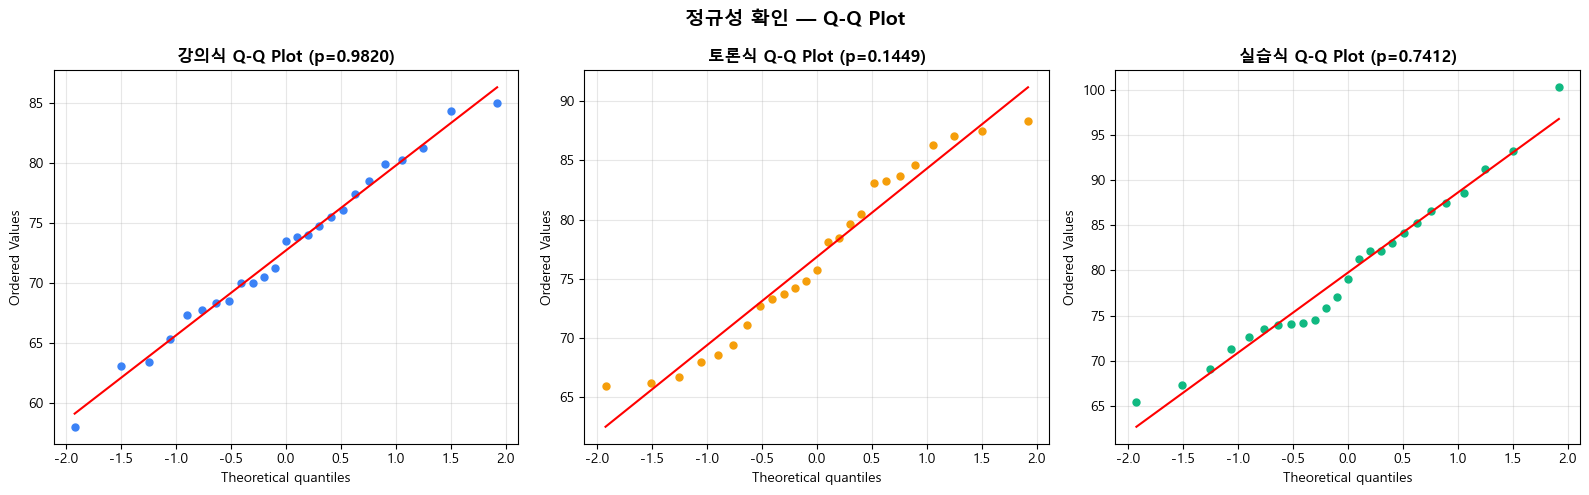

In [7]:
# ── Q-Q Plot (3집단) ──
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("정규성 확인 — Q-Q Plot", fontsize=14, fontweight='bold')

for ax, data, name, color in [(axes[0], lecture, '강의식', '#3B82F6'),
                                (axes[1], discussion, '토론식', '#F59E0B'),
                                (axes[2], practice, '실습식', '#10B981')]:
    stats.probplot(data, dist="norm", plot=ax)
    sw_p = stats.shapiro(data).pvalue
    ax.set_title(f"{name} Q-Q Plot (p={sw_p:.4f})", fontsize=12, fontweight='bold')
    ax.get_lines()[0].set_markerfacecolor(color)
    ax.get_lines()[0].set_markeredgecolor(color)
    ax.get_lines()[0].set_markersize(5)
    ax.get_lines()[1].set_color('red')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# ── 1단계-B: Levene 등분산 검정 ──
print("\n[1단계-B] Levene 등분산 검정")
print("=" * 60)

# TODO: Levene 등분산 검정 수행 (stats.levene)
lev_stat, lev_p = stats.levene(lecture, discussion, practice)

lev_stat_viz = lev_stat if lev_stat is not None else 0
lev_p_viz = lev_p if lev_p is not None else 0
print(f"  F = {lev_stat_viz:.4f}, p = {lev_p_viz:.4f}")

if lev_p is not None and lev_p > 0.05:
    print("  등분산 가정 충족: One-way ANOVA 사용")
    equal_var = True
else:
    print("  등분산 가정 위반: Welch's ANOVA 사용")
    equal_var = False


[1단계-B] Levene 등분산 검정
  F = 0.8840, p = 0.4175
  등분산 가정 충족: One-way ANOVA 사용


In [10]:
# ── 종합 판단 및 검정 방법 선택 ──
print("\n[종합 판단]")
print("-" * 40)

# TODO: normality_ok, equal_var 조합에 따라 test_method를 결정하세요
test_method = "One-way ANOVA"

print(f"  선택된 검정: {test_method}")


[종합 판단]
----------------------------------------
  선택된 검정: One-way ANOVA


#### 2단계: 검정 수행

In [12]:
df_anova.head()

,교육방법,점수
0,강의식,58.0
1,강의식,74.7
2,강의식,81.2
3,강의식,70.0
4,강의식,79.9


In [15]:
# ── 2단계: ANOVA 검정 수행 ──
print(f"[2단계] {test_method} 검정")
print("=" * 60)

# TODO: test_method에 따라 적절한 검정을 수행하세요
# 아래 변수들을 채워야 합니다: f_p (p-value), eta_sq (효과크기)
f_p = None
eta_sq = None
omega_sq = None


# TODO: One-way ANOVA 수행

# (1) stats.f_oneway(lecture, discussion, practice) → F통계량, p-value
f_stat, f_p = stats.f_oneway(lecture, discussion, practice)
print(f"  F 통계량: {f_stat:.4f}")  # F = MS_between / MS_within (집단 간 변동 / 집단 내 변동)
print(f"  p-value: {f_p:.4f}")      # p < 0.05면 H₀ 기각 (집단 간 차이 존재)
# 귀무 기각 -> 대립가설 지지
# 교육방법간의 차이가 있을 것이다.

# (2) pg.anova(dv='점수', between='교육방법', data=df_anova, detailed=True) → 상세 테이블
aov = pg.anova(dv='점수', between='교육방법', data=df_anova, detailed=True) #between 범주
display(aov)

# 	Source	SS	DF	MS	F	p-unc	np2
# 0	교육방법	625.017867	2	312.508933	5.401162	0.006523	0.130459
# 1	Within	4165.889600	72	57.859578	NaN	NaN	NaN

# (3) η² = aov['np2'].values[0]
eta_sq = aov['np2'].values[0] 
print(f"η² (에타제곱) = {eta_sq:.4f}")

# (4) ω² 수동 계산: (SS_B - df_B * MS_W) / (SS_T + MS_W)

ss_b = aov['SS'].values[0]  # 집단 간 제곱합 (Between-group Sum of Squares)
                                # → 집단 평균들 간의 차이로 설명되는 변동
ss_w = aov['SS'].values[1]  # 집단 내 제곱합 (Within-group Sum of Squares)
                            # → 각 집단 내부의 개별 데이터 변동 (오차)
df_b = aov['DF'].values[0]  # 집단 간 자유도 (Between-group degrees of freedom)
                            # → df_between = k - 1 (k: 집단 수)
ms_w = aov['MS'].values[1]  # 집단 내 평균제곱 (Within-group Mean Square)
                            # → MS_within = SS_within / df_within
                            # → 오차의 평균 크기 (분산 추정치)
ss_t = ss_b + ss_w          # 총 제곱합 (Total Sum of Squares)
                            # → 전체 데이터의 총 변동량
omega_sq = (ss_b - df_b * ms_w) / (ss_t + ms_w)
print(f"  ω² (오메가제곱) = {omega_sq:.4f}")


# 판정
if f_p is not None:
    verdict = 'H₀ 기각: 적어도 하나의 집단 평균이 다릅니다' if f_p < 0.05 else 'H₀ 기각 실패: 집단 평균이 모두 같다고 볼 수 있습니다'
    print(f"판정 (α=0.05): {verdict}")

# 효과크기 해석
if eta_sq is not None:
    size_eta = '작은' if eta_sq < 0.06 else '중간' if eta_sq < 0.14 else '큰'
    print(f"[효과크기] η² = {eta_sq:.4f} ({size_eta} 효과)")
    print(f"  해석: 0.01 작은, 0.06 중간, 0.14 큰")

[2단계] One-way ANOVA 검정
  F 통계량: 5.4012
  p-value: 0.0065


,Source,SS,DF,MS,F,p-unc,np2
0,교육방법,625.017867,2,312.508933,5.401162,0.006523,0.130459
1,Within,4165.889600,72,57.859578,NaN,NaN,NaN


η² (에타제곱) = 0.1305
  ω² (오메가제곱) = 0.1050
판정 (α=0.05): H₀ 기각: 적어도 하나의 집단 평균이 다릅니다
[효과크기] η² = 0.1305 (중간 효과)
  해석: 0.01 작은, 0.06 중간, 0.14 큰


#### 3단계: 사후검정 — 어떤 집단 쌍이 다른가?

ANOVA가 유의하면 **"적어도 하나가 다르다"** 는 것만 알 수 있습니다.
**어떤 집단 쌍**이 다른지 확인하려면 사후검정이 필요합니다.

##### 사후검정 3가지 방법

| 검정 방법 | 사후검정 | 적용 조건 | 특징 |
|-----------|----------|----------|------|
| One-way ANOVA | **Tukey HSD** | 정규성 + 등분산 | 모든 쌍을 동시에 비교, 다중비교 보정 포함 |
| Welch's ANOVA | **Games-Howell** | 정규성 + 등분산 위반 | 각 쌍별 별도 자유도, 등분산 가정 불필요 |
| Kruskal-Wallis | **Dunn 검정** | 정규성 위반 (비모수) | 순위 기반 비교, Bonferroni 보정 |

##### 사후검정 결과 해석 방법

**1. Tukey HSD (Honestly Significant Difference)**
- **출력 항목**:
- `group1`, `group2`: 비교하는 두 집단
- `meandiff`: 평균 차이 (group2 - group1)
- `p-adj`: 다중비교 **보정된** p-value (adjusted p-value)
- `lower`, `upper`: 평균 차이의 95% 신뢰구간
- `reject`: H₀ 기각 여부 (True = 유의한 차이)
- **`p-adj`와 `reject`의 관계**:
- `reject`는 별도의 값이 아니라, `p-adj < 0.05`이면 `True`, `p-adj ≥ 0.05`이면 `False`로 표시하는 편의 컬럼입니다
- 즉, **`p-adj`가 실제 검정 결과**이고 `reject`는 이를 보기 쉽게 정리한 것입니다
- **왜 "보정된(adjusted)" p-value인가요?**
  - 3집단이면 3쌍(A-B, A-C, B-C)을 비교합니다. 비교를 여러 번 하면 우연히 유의하게 나올 확률(1종 오류)이 높아집니다
  - 예: t-검정 3번 반복 시 1종 오류율 = 1 − 0.95³ ≈ **14.3%** (5%가 아님!)
  - Tukey HSD는 Studentized Range Distribution을 사용하여 이 오류율을 5%로 유지합니다
  - 따라서 `p-adj`는 일반 t-검정의 p-value보다 더 보수적(큰 값)으로 나옵니다

**2. Games-Howell (등분산 위반 시 사용)**
- **결과 해석**:
- `pval < 0.05` → 두 집단 간 유의한 차이 존재
- `pval ≥ 0.05` → 두 집단 간 차이 없음
- **출력 항목**:
- `A`, `B`: 비교하는 두 집단
- `mean(A)`, `mean(B)`: 각 집단의 평균
- `diff`: 평균 차이 (A - B)
- `se`: 표준오차 (Standard Error)
- `T`: 검정통계량 (Welch's t-statistic)
- `df`: 자유도 (Welch-Satterthwaite 조정)
- `pval`: p-value (Games-Howell 보정)
- `hedges`: Hedges' g (효과크기, 편향 조정된 Cohen's d)

**3. Dunn 검정 (비모수 사후검정)**
- **결과 해석**:
- 결과는 **p-value 행렬** 형태로 출력됩니다
- `p < 0.05` → 두 집단 간 유의한 차이 (순위 기반)
- `p ≥ 0.05` → 두 집단 간 차이 없음
- **Bonferroni 보정**: 다중비교로 인한 1종 오류율 증가 방지
  - 보정 후 p-value = 원래 p-value × 비교 횟수
  - 더 엄격한 기준 적용 (보수적)
- **출력**: 행렬 형태의 p-value 테이블 (대각선은 1.0, 대칭 구조)

<img src="images/pr_05/사후검정_가이드.png" width="100%">

In [ ]:
# ── 3단계: 사후검정 ──
print(f"\n[3단계] 사후검정")
print("=" * 60)


# TODO: Tukey HSD 사후검정 수행
tukey = pairwise_tukeyhsd(df_anova['점수'], df_anova['교육방법'], alpha=0.05)
print(tukey)
# ============================================================
# Multiple Comparison of Means - Tukey HSD, FWER=0.05 
# ====================================================
# group1 group2 meandiff p-adj   lower   upper  reject
# ----------------------------------------------------
#    강의식    실습식    7.036 0.0046  1.8873 12.1847   True
#    강의식    토론식    4.128 0.1408 -1.0207  9.2767  False
#    실습식    토론식   -2.908 0.3717 -8.0567  2.2407  False

print(f"\n 쌍별 Cohen's d")
print("-" * 40)
group_data = {'강의식': lecture, '토론식': discussion, '실습식': practice}
for (group_name1, group_data1), (group_name2, group_data2) in combinations(group_data.items(), 2): #조합 3C2 = 3개중에 2개를 뽑음
    # eftype='cohen': 일반 Cohen's d (편향 있음, 대표본에서 문제 없음)
    # eftype='hedges': Hedges' g (편향 조정, 소표본에서 권장)
    d = pg.compute_effsize(group_data1, group_data2, eftype='cohen')
    size_d = '매우 작은' if abs(d) < 0.2 else '작은' if abs(d) < 0.5 else '중간' if abs(d) < 0.8 else '큰'
    print(f"  {group_name1} vs {group_name2}: d = {d:.3f} ({size_d} 효과)")

    


[3단계] 사후검정
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   강의식    실습식    7.036 0.0046  1.8873 12.1847   True
   강의식    토론식    4.128 0.1408 -1.0207  9.2767  False
   실습식    토론식   -2.908 0.3717 -8.0567  2.2407  False
----------------------------------------------------

 쌍별 Cohen's d
----------------------------------------
  강의식 vs 토론식: d = -0.585 (중간 효과)
  강의식 vs 실습식: d = -0.907 (큰 효과)
  토론식 vs 실습식: d = -0.365 (작은 효과)


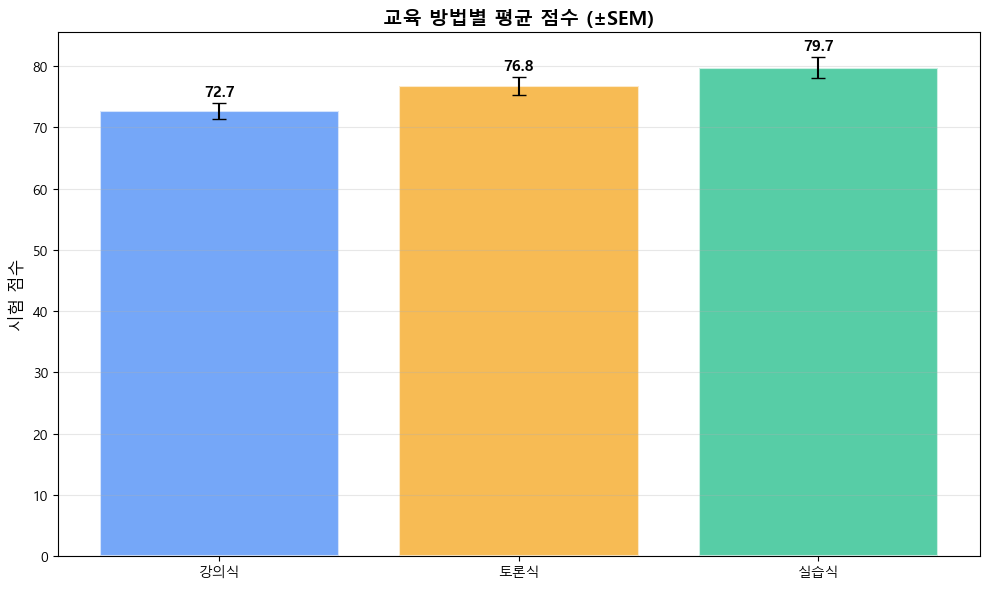


[핵심 포인트]
  ANOVA는 '하나라도 다른가?'를 검정하고, 사후검정으로 '어디가 다른가?'를 확인합니다
  전체 효과크기(η²)보다 사후검정의 쌍별 Cohen's d가 실질적으로 더 중요합니다


In [18]:
# ── 사후검정 결과 시각화 ──
fig, ax = plt.subplots(figsize=(10, 6))

# ═══ 데이터 준비 ═══
group_data = {'강의식': lecture, '토론식': discussion, '실습식': practice}

# 각 집단의 평균 (표본평균)
means = [d.mean() for d in group_data.values()]

# 표준오차 (Standard Error of Mean, SEM) 계산
# SEM = 표준편차 / √n
# - 표본평균의 불확실성(변동성)을 나타냅니다
# - 표준편차(SD)는 개별 데이터의 변동성, SEM은 평균의 변동성
# - SEM이 작을수록 표본평균이 모집단 평균에 가까움 (정확한 추정)
# - ddof=1: 불편 표준편차 사용 (n-1로 나눔, 표본 표준편차)
sems = [d.std(ddof=1) / np.sqrt(len(d)) for d in group_data.values()]

# ═══ 막대 그래프 + 오차막대 ═══
# yerr=sems: 각 막대에 오차막대(error bar) 추가
#   - 오차막대는 ±SEM 범위를 표시 (평균의 신뢰 범위)
#   - 막대 길이 = 평균, 오차막대 = 평균의 불확실성
# capsize=5: 오차막대 끝의 수평선 길이 (시각적 명확성)
bars = ax.bar(group_data.keys(), means, yerr=sems, capsize=5,
              color=colors, alpha=0.7, edgecolor='white', linewidth=1.5)

# ═══ 평균값 텍스트 표시 ═══
# 각 막대 위에 평균값을 숫자로 표시
for bar, mean, sem in zip(bars, means, sems):
    # x 좌표: bar.get_x() + bar.get_width()/2.
    #   → 막대의 중앙 (막대 시작점 + 막대 너비의 절반)

    # y 좌표: mean + sem + 0.5
    #   → mean: 막대의 높이 (평균값)
    #   → sem: 오차막대의 상단 끝 (평균 + 표준오차)
    #   → 0.5: 추가 여백 (오차막대와 텍스트 사이 간격, 가독성 향상)
    #   → 최종 위치: 오차막대 위쪽 0.5만큼 띄워서 텍스트 배치

    # f'{mean:.1f}': 평균값을 소수점 1자리로 표시
    # ha='center': 텍스트 수평 정렬 (막대 중앙)
    # va='bottom': 텍스트 수직 정렬 (텍스트 아래쪽이 y 좌표에 위치)
    ax.text(bar.get_x() + bar.get_width()/2., mean + sem + 0.5,
            f'{mean:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('시험 점수', fontsize=12)
ax.set_title('교육 방법별 평균 점수 (±SEM)', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n[핵심 포인트]")
print("  ANOVA는 '하나라도 다른가?'를 검정하고, 사후검정으로 '어디가 다른가?'를 확인합니다")
print("  전체 효과크기(η²)보다 사후검정의 쌍별 Cohen's d가 실질적으로 더 중요합니다")

### 시나리오 2: Welch's ANOVA — 마케팅 채널별 매출 비교

**상황**: 한 온라인 쇼핑몰에서 3가지 마케팅 채널(SNS, 검색광고, 이메일)의

고객당 매출을 비교합니다. 채널별 매출 분산이 다를 수 있어 등분산 검정이 필요합니다.

In [29]:
# ── 시나리오 2: 데이터 생성 ──
print("\n[시나리오 2] Welch's ANOVA — 마케팅 채널별 매출 비교")
print("=" * 60)

np.random.seed(200)
sns_sales = np.round(np.random.normal(85, 15, 30), 1)      # SNS: 넓은 분산
search_sales = np.round(np.random.normal(92, 8, 30), 1)    # 검색광고: 좁은 분산
email_sales = np.round(np.random.normal(78, 20, 30), 1)    # 이메일: 매우 넓은 분산

for name, data in [('SNS', sns_sales), ('검색광고', search_sales), ('이메일', email_sales)]:
    print(f"  {name}: 평균={data.mean():.1f}, 표준편차={data.std(ddof=1):.1f}")

# ── 정규성 검정 ──
print(f"\n[1] Shapiro-Wilk 정규성 검정")
print("-" * 40)
norm_ok_2 = True
for name, data in [('SNS', sns_sales), ('검색광고', search_sales), ('이메일', email_sales)]:
    # TODO: Shapiro-Wilk 정규성 검정 수행
    stat_sw, p_sw = stats.shapiro(data)

    result = "정규성 유지" if (p_sw is not None and p_sw > 0.05) else "정규성 위반"
    if p_sw is not None and p_sw <= 0.05:
        norm_ok_2 = False
    stat_viz = stat_sw if stat_sw is not None else 0
    p_viz = p_sw if p_sw is not None else 0
    print(f"  {name}: W={stat_viz:.4f}, p={p_viz:.4f} ({result})")

# ── 등분산 검정 ──
print(f"\n[2] Levene 등분산 검정")
print("-" * 40)
# TODO: Levene 등분산 검정 수행 (stats.levene)
lev_stat2, lev_p2 = stats.levene(sns_sales, search_sales, email_sales)

lev_stat2_viz = lev_stat2 if lev_stat2 is not None else 0
lev_p2_viz = lev_p2 if lev_p2 is not None else 0
print(f"  F = {lev_stat2_viz:.4f}, p = {lev_p2_viz:.4f}")
equal_var_2 = lev_p2 is not None and lev_p2 > 0.05
if equal_var_2:
    print("  등분산 가정 충족")
else:
    print("  등분산 가정 위반: Welch's ANOVA 사용")


[시나리오 2] Welch's ANOVA — 마케팅 채널별 매출 비교
  SNS: 평균=88.0, 표준편차=15.3
  검색광고: 평균=93.4, 표준편차=9.7
  이메일: 평균=77.5, 표준편차=19.3

[1] Shapiro-Wilk 정규성 검정
----------------------------------------
  SNS: W=0.9624, p=0.3563 (정규성 유지)
  검색광고: W=0.9751, p=0.6871 (정규성 유지)
  이메일: W=0.9892, p=0.9867 (정규성 유지)

[2] Levene 등분산 검정
----------------------------------------
  F = 4.7289, p = 0.0112
  등분산 가정 위반: Welch's ANOVA 사용


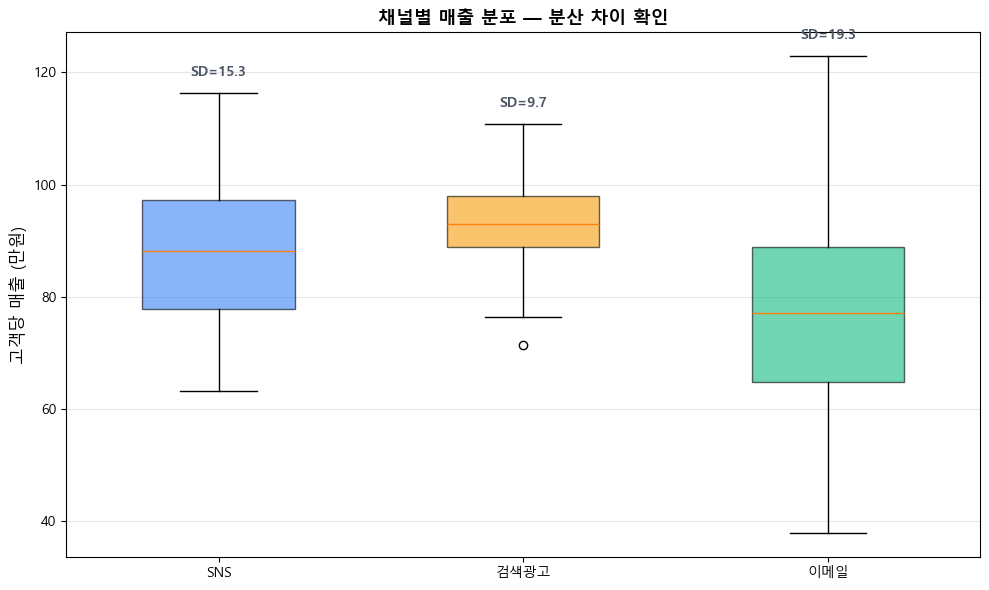

  박스의 크기(IQR)가 채널마다 다릅니다 = 등분산 위반의 시각적 근거입니다


In [30]:
# ── 분포 시각화 (등분산 위반 확인) ──
fig, ax = plt.subplots(figsize=(10, 6))

data_ch = [sns_sales, search_sales, email_sales]
labels_ch = ['SNS', '검색광고', '이메일']
colors_ch = ['#3B82F6', '#F59E0B', '#10B981']

bp2 = ax.boxplot(data_ch, labels=labels_ch, patch_artist=True, widths=0.5)
for patch, color in zip(bp2['boxes'], colors_ch):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# 표준편차 표시
for i, (data, label) in enumerate(zip(data_ch, labels_ch)):
    ax.text(i + 1, data.max() + 3, f'SD={data.std(ddof=1):.1f}',
            ha='center', fontsize=10, color='#4B5563', fontweight='bold')

ax.set_ylabel('고객당 매출 (만원)', fontsize=12)
ax.set_title('채널별 매출 분포 — 분산 차이 확인', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("  박스의 크기(IQR)가 채널마다 다릅니다 = 등분산 위반의 시각적 근거입니다")

In [ ]:
# ── Welch's ANOVA ──
print(f"[3] Welch's ANOVA")
print("=" * 60)

groups2 = ['SNS'] * 30 + ['검색광고'] * 30 + ['이메일'] * 30
sales2 = np.concatenate([sns_sales, search_sales, email_sales])
df_sales = pd.DataFrame({'채널': groups2, '매출': sales2})

# TODO: Welch's ANOVA 수행
# pg.welch_anova(dv='매출', between='채널', data=df_sales)
# 결과에서 F, p-unc, np2 추출
welch2 = pg.welch_anova(dv='매출', between='채널', data=df_sales)
display(welch2)
f_val2 = welch2['F'].values[0] 
p_val2 = welch2['p-unc'].values[0] 
eta2 = welch2['np2'].values[0] 

if p_val2 is not None:
    verdict2 = 'H₀ 기각: 채널별 매출에 유의한 차이가 있습니다' if p_val2 < 0.05 else 'H₀ 기각 실패'
    print(f"판정: {verdict2}")

if eta2 is not None:
    size_eta2 = '작은' if eta2 < 0.06 else '중간' if eta2 < 0.14 else '큰'
    print(f"  [효과크기] η² = {eta2:.4f} ({size_eta2} 효과)")

# F통계량 
#ddof1 : 분자의 자유도 (집단수 - 1)
#ddof2 : 분모 자유도 (전체 표본수 - 집단수)


[3] Welch's ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,채널,2,53.410663,8.194987,0.000787,0.161346


판정: H₀ 기각: 채널별 매출에 유의한 차이가 있습니다
  [효과크기] η² = 0.1613 (큰 효과)


# 통계 : 실습 5개 --> 3회독!
# 오늘 --> 설날끝나고는 머신러닝이 더 본격적이기 때문에
# 통계 복습할 시간은 지금 ~ 설날 밖에 없음!

In [ ]:
# ── Games-Howell 사후검정 ──
if p_val2 is not None and p_val2 < 0.05:
    print(f"\n[4] Games-Howell 사후검정")
    print("=" * 60)

    # TODO: Games-Howell 사후검정 수행
    gh2 = pg.pairwise_gameshowell(dv='매출', between='채널', data=df_sales)
    display(gh2)
    # 결과에서 A, B, diff, pval, hedges 컬럼을 활용하여 해석하세요
    


    # TODO: 쌍별 결과 해석 (유의성 판단 + 방향 해석 + 효과크기)
    # - pval < 0.05 → 유의한 차이
    # - diff > 0 → A가 B보다 높음
    # - Hedges' g 해석: |g| < 0.2 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, ≥0.8 큰
    


[4] Games-Howell 사후검정


,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,SNS,검색광고,88.033333,93.370000,-5.336667,3.304040,-1.615195,49.097232,0.248912,-0.411625
1,SNS,이메일,88.033333,77.496667,10.536667,4.500467,2.341239,55.049697,0.058433,0.596654
2,검색광고,이메일,93.370000,77.496667,15.873333,3.950390,4.018169,42.709328,0.000671,1.024013


### 시나리오 3: Kruskal-Wallis — 고객 만족도 비교

**상황**: 3개 지점(A, B, C)의 고객 만족도(1~10점 척도)를 비교합니다.

점수가 이산형(1~10)이고 분포가 치우쳐 있어 비모수 검정이 적절합니다.

In [36]:
# ── 시나리오 3: 데이터 생성 ──
print("\n[시나리오 3] Kruskal-Wallis — 고객 만족도 비교")
print("=" * 60)

np.random.seed(300)
# 만족도 데이터 (비대칭 분포)
branch_a = np.clip(np.round(np.random.exponential(3, 20) + 4, 0), 1, 10).astype(int)
branch_b = np.clip(np.round(np.random.normal(6, 1.5, 20), 0), 1, 10).astype(int)
branch_c = np.clip(np.round(np.random.normal(8, 1.0, 20), 0), 1, 10).astype(int)

for name, data in [('지점 A', branch_a), ('지점 B', branch_b), ('지점 C', branch_c)]:
    print(f"  {name}: 중앙값={np.median(data):.0f}, 평균={data.mean():.1f}")

# ── 정규성 검정 ──
print(f"\n[1] Shapiro-Wilk 정규성 검정")
print("-" * 40)
for name, data in [('지점 A', branch_a), ('지점 B', branch_b), ('지점 C', branch_c)]:
    stat_sw, p_sw = stats.shapiro(data)
    result = "정규성 유지" if p_sw > 0.05 else "정규성 위반"
    print(f"  {name}: W={stat_sw:.4f}, p={p_sw:.4f} ({result})")

print("\n  정규성을 위반하므로 Kruskal-Wallis 검정을 사용합니다")


[시나리오 3] Kruskal-Wallis — 고객 만족도 비교
  지점 A: 중앙값=6, 평균=6.5
  지점 B: 중앙값=6, 평균=5.9
  지점 C: 중앙값=9, 평균=8.3

[1] Shapiro-Wilk 정규성 검정
----------------------------------------
  지점 A: W=0.9426, p=0.2682 (정규성 유지)
  지점 B: W=0.9096, p=0.0627 (정규성 유지)
  지점 C: W=0.8871, p=0.0238 (정규성 위반)

  정규성을 위반하므로 Kruskal-Wallis 검정을 사용합니다


In [ ]:
# ── Kruskal-Wallis 검정 ──
print(f"\n[2] Kruskal-Wallis 검정")
print("=" * 60)

# TODO: Kruskal-Wallis 검정 수행 (stats.kruskal)
h_stat3, kw_p3 = stats.kruskal(branch_a, branch_b, branch_c)
print(f"  H 통계량: {h_stat3:.4f}")
print(f"  p-value: {kw_p3:.4f}")

# TODO: η²_H 효과크기 계산
# 공식: η²_H = (H − k + 1) / (N − k)  (k=집단수, N=전체 표본 크기)
k3 = 3
N3 = len(branch_a) + len(branch_b) + len(branch_c)
eta_sq_h3 = (h_stat3 - k3 + 1) / (N3 - k3)

if h_stat3 is not None:
    print(f"  H 통계량: {h_stat3:.4f}")
    print(f"  p-value: {kw_p3:.4f}")

if eta_sq_h3 is not None:
    size_eta3 = '작은' if eta_sq_h3 < 0.06 else '중간' if eta_sq_h3 < 0.14 else '큰'
    print(f"\n  [효과크기] η²_H = {eta_sq_h3:.4f} ({size_eta3} 효과)")

if kw_p3 is not None:
    verdict3 = 'H₀ 기각: 지점별 만족도에 유의한 차이가 있습니다' if kw_p3 < 0.05 else 'H₀ 기각 실패'
    print(f"  판정: {verdict3}")


[2] Kruskal-Wallis 검정
  H 통계량: 17.8517
  p-value: 0.0001
  H 통계량: 17.8517
  p-value: 0.0001

  [효과크기] η²_H = 0.2781 (큰 효과)
  판정: H₀ 기각: 지점별 만족도에 유의한 차이가 있습니다


In [ ]:
# ── Dunn 사후검정 ──
if kw_p3 is not None and kw_p3 < 0.05:
    print(f"\n[3] Dunn 사후검정 (Bonferroni 보정)")
    print("=" * 60)

    groups3 = ['지점 A'] * 20 + ['지점 B'] * 20 + ['지점 C'] * 20
    satisfaction3 = np.concatenate([branch_a, branch_b, branch_c])
    df_sat = pd.DataFrame({'지점': groups3, '만족도': satisfaction3})
    # display(df_sat.sample(10))

    # TODO: Dunn 사후검정 수행
    # sp.posthoc_dunn(df_sat, val_col='만족도', group_col='지점', p_adjust='bonferroni')
    dunn3 = sp.posthoc_dunn(df_sat, val_col='만족도', group_col='지점', p_adjust='bonferroni')
    display(dunn3)
    # 결과는 p-value 행렬 형태 (대칭 구조)
    # A-C 지점의 차이가 있고
    # b-c 지점의 차이가 있다.

    # TODO: 쌍별 결과 해석
    # - p < 0.05 → 유의한 차이
    # - 비모수 검정이므로 중앙값으로 방향 해석 (np.median)

    group_names = dunn3.columns.tolist()
    medians = {name: np.median(data) for name, data in [('지점 A', branch_a), ('지점 B', branch_b), ('지점 C', branch_c)]}


    for i in range(len(group_names)):
        for j in range(i + 1, len(group_names)):
            g1, g2 = group_names[i], group_names[j]
            p_val = dunn3.iloc[i, j]
            sig = "유의한 차이" if p_val < 0.05 else "유의하지 않음"

            # 비모수 검정이므로 중앙값으로 방향 해석
            m1, m2 = medians[g1], medians[g2]
            if m1 > m2:
                direction = f"{g1}의 중앙값({m1:.0f})이 {g2}({m2:.0f})보다 높습니다"
            elif m1 < m2:
                direction = f"{g2}의 중앙값({m2:.0f})이 {g1}({m1:.0f})보다 높습니다"
            else:
                direction = f"두 집단의 중앙값이 동일합니다 ({m1:.0f})"

            print(f"  {g1} vs {g2}: {sig} (p={p_val:.4f})")
            print(f"    → {direction}")

# 만족도 C지점이 A,B지점보다 좋다


[3] Dunn 사후검정 (Bonferroni 보정)


,지점 A,지점 B,지점 C
지점 A,1.000000,1.000000,0.005029
지점 B,1.000000,1.000000,0.000177
지점 C,0.005029,0.000177,1.000000


  지점 A vs 지점 B: 유의하지 않음 (p=1.0000)
    → 지점 A의 중앙값(6)이 지점 B(6)보다 높습니다
  지점 A vs 지점 C: 유의한 차이 (p=0.0050)
    → 지점 C의 중앙값(9)이 지점 A(6)보다 높습니다
  지점 B vs 지점 C: 유의한 차이 (p=0.0002)
    → 지점 C의 중앙값(9)이 지점 B(6)보다 높습니다


### 흔한 오해

| 오해 | 진실 |
|------|------|
| "ANOVA가 유의하면 모든 집단이 다르다" | "적어도 하나"만 다르다는 뜻입니다. 사후검정으로 확인이 필요합니다 |
| "ANOVA 검정은 정규성 만족이 필수다" | 대표본에서는 강건하지만, 소표본에서 정규성 위반 시 Kruskal-Wallis를 사용합니다 |
| "η²만 보면 충분하다" | 전체 효과크기보다 **쌍별 효과크기가**가 실질적으로 더 유용합니다 |

---

## Part 2: 상관분석

### 2.1 주요 용어 정리

| 용어              | 영어                            | 정의                                                       |
|-------------------|---------------------------------|------------------------------------------------------------|
| 상관계수          | Correlation Coefficient         | 두 변수 간 **관계의 강도와 방향**을 나타내는 수치 (−1~+1) |
| 피어슨 상관계수   | Pearson Correlation (r)         | 두 **연속형** 변수 간의 **선형 관계**를 측정 (모수적 방법)       |
| 스피어만 상관계수 | Spearman Correlation (ρ)        | **순위(rank)** 기반 **단조 관계** 측정 — 비선형·이상치에 강건 (비모수적)   |
| 공분산            | Covariance                      | 두 변수가 함께 변하는 정도 (단위에 의존)                     |
| 산점도            | Scatter Plot                    | 두 변수의 관계를 시각적으로 보여주는 그래프                  |
| 히트맵            | Heatmap                         | 상관 행렬을 색상으로 시각화한 그래프                         |
| 교란변수          | Confounding Variable            | 두 변수 모두에 영향을 주어 잘못된 상관을 만드는 숨은 변수    |

> **주의**: "상관계수"는 피어슨(선형)과 스피어만(단조)을 모두 포함하는 일반 용어입니다. 
> 구체적으로 어떤 상관계수를 사용했는지 명시해야 합니다.

> **교란변수 예시** : 아이스크림 판매량과 익사 사고 수는 강한 양의 상관을 보이지만, \
> 실제 원인은 **기온(여름철)** 이라는 교란변수입니다. \
> 더운 날씨 → 아이스크림 소비 ↑, 수영 인구 ↑ → 익사 사고 ↑. \
> 이처럼 교란변수를 무시하면 **"상관관계 = 인과관계"** 라는 오류에 빠질 수 있습니다.

### 2.2 피어슨 상관계수 (Pearson Correlation)

#### 정의

$$r = \frac{Cov(X, Y)}{S_X \cdot S_Y} = \frac{\sum (X_i - \bar{X})(Y_i - \bar{Y})}{\sqrt{\sum (X_i - \bar{X})^2 \cdot \sum (Y_i - \bar{Y})^2}}$$

- **공분산(Cov)** 을 각 변수의 표준편차로 나누어 **단위를 제거**하고 **−1~+1로 정규화**한 값입니다.

- r = +1: 완벽한 양의 선형 관계

- r = −1: 완벽한 음의 선형 관계

- r = 0: 선형 관계 없음 (비선형 관계는 있을 수 있습니다)

> **같은 인덱스*: 피어슨 상관계수는 $(X_i, Y_i)$가 **같은 관측 단위(i)** 에서 측정된 쌍(pair)임을 전제합니다. \
> 예: 같은 날짜($i$)의 기온($X_i$)과 아이스크림 판매량($Y_i$)은 유효한 쌍이지만, 서로 다른 날짜의 값을 임의로 짝지으면 의미가 없습니다.

#### 해석 기준

| abs(r) 범위 | 해석     | 비고 |
|-----------|----------|------|
| < 0.3     | 약한 상관 | 분야에 따라 유의미할 수 있습니다 |
| 0.3 ~ 0.7 | 중간 상관 | 실무에서 자주 관찰되는 범위입니다 |
| ≥ 0.7     | 강한 상관 | 물리학 등에서는 0.95 이상이 기준이 될 수 있습니다 |

> **주의**: 해석 기준은 분야마다 다릅니다. 사회과학에서 r=0.3은 중요한 발견일 수 있지만,
> 물리학에서는 의미가 없을 수 있습니다.



### 2.3 스피어만 상관계수 (Spearman Correlation)

**스피어만 상관계수**는 원래 값 대신 **순위(rank)** 를 사용하여 상관을 측정합니다.

| 특성 | 피어슨 (Pearson) | 스피어만 (Spearman) |
|------|------------------|---------------------|
| 기반 | **원래 값** | **순위 (rank)** |
| 측정 대상 | 선형 관계 | 단조(monotonic) 관계 |
| 이상치 민감도 | **높음** (평균·분산 기반) | **낮음** (순위 기반) |
| 적합한 데이터 | 연속형 변수 | 서열형, 이상치 존재 |
| 사용 예시 | 키↔체중, 광고비↔매출 | 만족도 점수(1~5), 이상치가 있는 데이터 |

> *단조(monotonic) 관계: 한 변수가 증가할 때 다른 변수가 **방향은 일정하게** 증가(또는 감소)하되, \
> 그 비율은 달라도 되는 관계 (직선이 아니어도 OK)*

#### Pearson vs Spearman 비교 해석 가이드

두 상관계수를 **함께 실행한 뒤 비교**하면 데이터의 특성을 더 깊이 파악할 수 있습니다.

| 패턴 | 의미 | 예시 |
|------|------|------|
| Pearson ≈ Spearman | 관계가 **선형에 가까움** | 경력↔급여처럼 비례적으로 증가 |
| Pearson < Spearman | **비선형이지만 단조적** 관계 존재 | 학습시간↔점수 (초반 급상승 후 완만) |
| Pearson > Spearman | **이상치가 Pearson을 부풀렸을** 가능성 | 극단적 고소득자가 포함된 소득 데이터 |

#### 실무 팁: 어떤 상관계수를 선택할까?

| 상황 | 추천 방법 | 이유 |
|------|-----------|------|
| 연속형 변수 + 선형 관계 확인 | **Pearson** | 가장 검정력이 높음 |
| 순서형 변수 포함 | **Spearman** | 순위 기반이라 서열 데이터에 자연스러움 |
| 이상치가 의심되는 데이터 | **Spearman** | 순위 기반이라 이상치에 강건 |
| 확신이 없을 때 | **둘 다 실행 후 비교** | 차이가 크면 비선형·이상치 의심 |

> **핵심**: 확신이 없으면 **둘 다 돌려서 비교**하는 것이 가장 안전합니다!

### 2.4 상관계수와 가설검정

상관계수를 구했다고 해서 그것이 **우연이 아닌 진짜 관계**인지는 알 수 없습니다.

통계적 검정이 필요합니다.

- **귀무가설(H₀)**: 모집단에서 상관이 없다 (ρ = 0)

- **대립가설(H₁)**: 모집단에서 상관이 있다 (ρ ≠ 0)

| 결과 | 해석 |
|------|------|
| p < 0.05 | 우연이라고 보기 어렵다 → **유의한 상관** |
| p ≥ 0.05 | 우연일 수도 있다 → 상관이 있다고 단정할 수 없음 |

> **주의**: p-value가 작아도 **r 값이 작으면** 실질적 의미가 없을 수 있습니다.\
> 대표본에서는 아주 작은 r도 통계적으로 유의할 수 있으므로, **r 값과 p-value를 함께** 보고해야 합니다.

<img src="images/pr_05/상관계수_비교.png" width="100%">

### 시나리오 4: 상관분석 — 공부시간과 시험 점수

**상황**: 30명의 학생에 대해 주간 공부시간과 시험 점수의 관계를 분석합니다.

In [44]:
# ── 시나리오 4: 데이터 생성 ──
print("\n[시나리오 4] 상관분석 — 공부시간과 시험 점수")
print("=" * 60)

np.random.seed(400)
study_hours = np.round(np.random.uniform(1, 15, 30), 1)
# 양의 상관 + 약간의 노이즈
exam_scores = np.round(40 + 3.5 * study_hours + np.random.normal(0, 8, 30), 1)
exam_scores = np.clip(exam_scores, 0, 100)  # 0~100 범위 제한

print(f"  시험점수 샘플: {exam_scores[:10]}")
print(f"  표본 크기: {len(study_hours)}명")
print(f"  공부시간: 평균={study_hours.mean():.1f}시간, 범위={study_hours.min():.1f}~{study_hours.max():.1f}")
print(f"  시험점수: 평균={exam_scores.mean():.1f}점, 범위={exam_scores.min():.1f}~{exam_scores.max():.1f}")


[시나리오 4] 상관분석 — 공부시간과 시험 점수
  시험점수 샘플: [93.7 42.2 86.6 57.9 56.  39.5 86.1 74.5 89.5 68.8]
  표본 크기: 30명
  공부시간: 평균=8.0시간, 범위=1.2~14.6
  시험점수: 평균=70.9점, 범위=39.5~100.0


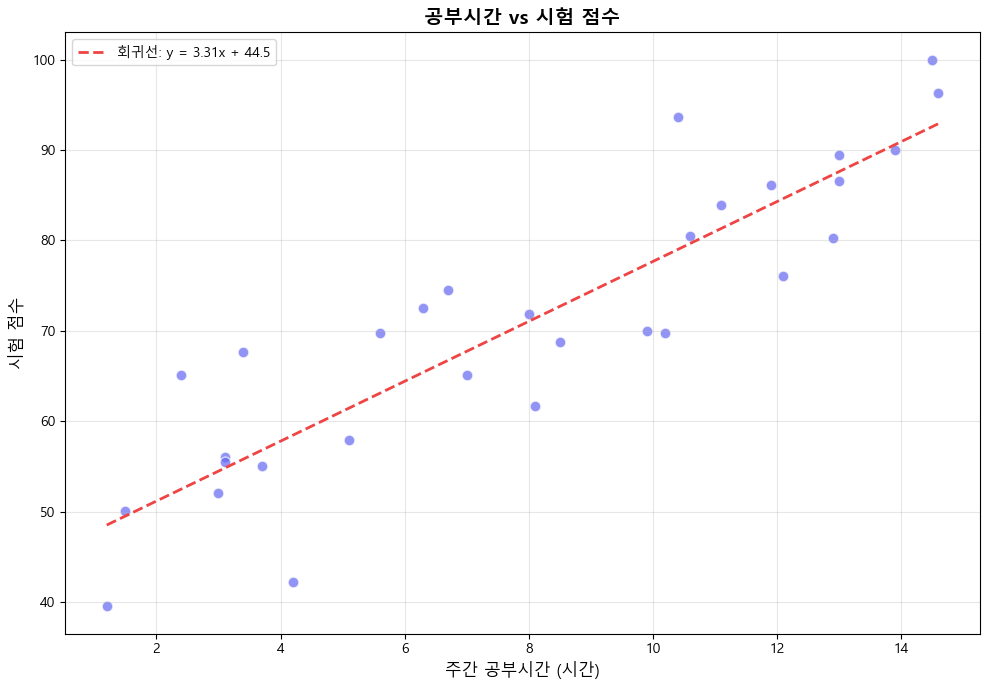

In [45]:
# ── 산점도 ──
fig, ax = plt.subplots(figsize=(10, 7))

# TODO 산점도 및 회귀선
ax.scatter(study_hours, exam_scores, color='#6366F1', alpha=0.7, s=60, edgecolors='white')

# 회귀선 추가
z = np.polyfit(study_hours, exam_scores, 1)
p = np.poly1d(z)
x_line = np.linspace(study_hours.min(), study_hours.max(), 100)
ax.plot(x_line, p(x_line), color='#EF4444', linewidth=2, linestyle='--',
        label=f'회귀선: y = {z[0]:.2f}x + {z[1]:.1f}')


ax.set_xlabel('주간 공부시간 (시간)', fontsize=12)
ax.set_ylabel('시험 점수', fontsize=12)
ax.set_title('공부시간 vs 시험 점수', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [47]:
# ── 피어슨 상관계수 ──
print("\n[1] 피어슨 상관계수 (Pearson r)")
print("-" * 40)

# TODO: 피어슨 상관계수 계산 (stats.pearsonr)
# 범위: -1 ≤ r ≤ 1 (1: 완벽한 양의 선형, 0: 선형 관계 없음, -1: 완벽한 음의 선형)
r_pearson, p_pearson = stats.pearsonr(study_hours, exam_scores)

if r_pearson is not None:
    size_r = '약한' if abs(r_pearson) < 0.3 else '중간' if abs(r_pearson) < 0.7 else '강한'
    direction = '양의' if r_pearson > 0 else '음의'
    print(f"  r = {r_pearson:.4f} ({size_r} {direction} 상관)")
    print(f"  p = {p_pearson:.4f}")
    sig_p = '유의한 상관 (p < 0.05)' if p_pearson < 0.05 else '유의하지 않음 (p ≥ 0.05)'
    print(f"  판정: {sig_p}")

    # TODO: 결정계수(r²) 계산 및 해석
    # r² = 한 변수가 다른 변수 분산의 몇 %를 설명하는지
    print(f"\n  결정계수 r² = {r_pearson**2:.4f}")
    print(f"  공부시간이 시험 점수 분산의 {r_pearson**2*100:.1f}%를 설명합니다")

# ── 스피어만 상관계수 ──
print(f"\n[2] 스피어만 상관계수 (Spearman ρ)")
print("-" * 40)

# TODO: 스피어만 상관계수 계산 (stats.spearmanr)
# 순위(rank) 기반 단조 관계 측정 — 이상치에 강건
r_spearman, p_spearman = stats.spearmanr(study_hours, exam_scores)

if r_spearman is not None:
    size_rs = '약한' if abs(r_spearman) < 0.3 else '중간' if abs(r_spearman) < 0.7 else '강한'
    direction_s = '양의' if r_spearman > 0 else '음의'
    print(f"  ρ = {r_spearman:.4f} ({size_rs} {direction_s} 상관)")
    print(f"  p = {p_spearman:.4f}")
    sig_sp = '유의한 상관 (p < 0.05)' if p_spearman < 0.05 else '유의하지 않음 (p ≥ 0.05)'
    print(f"  판정: {sig_sp}")

# ── 비교 ──
if r_pearson is not None and r_spearman is not None:
    print(f"\n[비교]")
    print(f"  Pearson r  = {r_pearson:.4f} (선형 관계)")
    print(f"  Spearman ρ = {r_spearman:.4f} (단조 관계)")
    print(f"  두 값이 비슷하면 선형 관계가 주된 패턴입니다")


[1] 피어슨 상관계수 (Pearson r)
----------------------------------------
  r = 0.8915 (강한 양의 상관)
  p = 0.0000
  판정: 유의한 상관 (p < 0.05)

  결정계수 r² = 0.7949
  공부시간이 시험 점수 분산의 79.5%를 설명합니다

[2] 스피어만 상관계수 (Spearman ρ)
----------------------------------------
  ρ = 0.9035 (강한 양의 상관)
  p = 0.0000
  판정: 유의한 상관 (p < 0.05)

[비교]
  Pearson r  = 0.8915 (선형 관계)
  Spearman ρ = 0.9035 (단조 관계)
  두 값이 비슷하면 선형 관계가 주된 패턴입니다


### 시나리오 5: 이상치의 영향 — Pearson vs Spearman

**상황**: 이상치가 상관계수에 미치는 영향을 확인합니다.

광고비와 매출 데이터에 극단적 이상치 하나를 추가하면 Pearson r이 크게 변합니다.

In [49]:
# ── 시나리오 5: 이상치의 영향 ──
print("\n[시나리오 5] 이상치의 영향 — Pearson vs Spearman")
print("=" * 60)

np.random.seed(500)
ad_cost = np.round(np.random.uniform(10, 100, 20), 1)
revenue = np.round(200 + 3 * ad_cost + np.random.normal(0, 30, 20), 1)

# 이상치 추가
ad_cost_outlier = np.append(ad_cost, 500)
revenue_outlier = np.append(revenue, 50)

# TODO: 이상치 없는 데이터에서 Pearson, Spearman 상관계수 계산
r_p1, p_p1 = stats.pearsonr(ad_cost, revenue)
r_s1, p_s1 = stats.spearmanr(ad_cost, revenue)

# TODO: 이상치 포함 데이터에서 Pearson, Spearman 상관계수 계산
r_p2, p_p2 = stats.pearsonr(ad_cost_outlier, revenue_outlier)
r_s2, p_s2 = stats.spearmanr(ad_cost_outlier, revenue_outlier)

r_p1_viz = r_p1 if r_p1 is not None else 0
r_s1_viz = r_s1 if r_s1 is not None else 0
r_p2_viz = r_p2 if r_p2 is not None else 0
r_s2_viz = r_s2 if r_s2 is not None else 0
print(f"  [이상치 없이] Pearson r = {r_p1_viz:.4f}, Spearman ρ = {r_s1_viz:.4f}")
print(f"  [이상치 포함] Pearson r = {r_p2_viz:.4f}, Spearman ρ = {r_s2_viz:.4f}")
print(f"\n  Pearson 변화량: {abs(r_p1_viz - r_p2_viz):.4f} (이상치에 민감)")
print(f"  Spearman 변화량: {abs(r_s1_viz - r_s2_viz):.4f} (이상치에 강건)")


[시나리오 5] 이상치의 영향 — Pearson vs Spearman
  [이상치 없이] Pearson r = 0.9264, Spearman ρ = 0.8830
  [이상치 포함] Pearson r = -0.5733, Spearman ρ = 0.6262

  Pearson 변화량: 1.4997 (이상치에 민감)
  Spearman 변화량: 0.2569 (이상치에 강건)


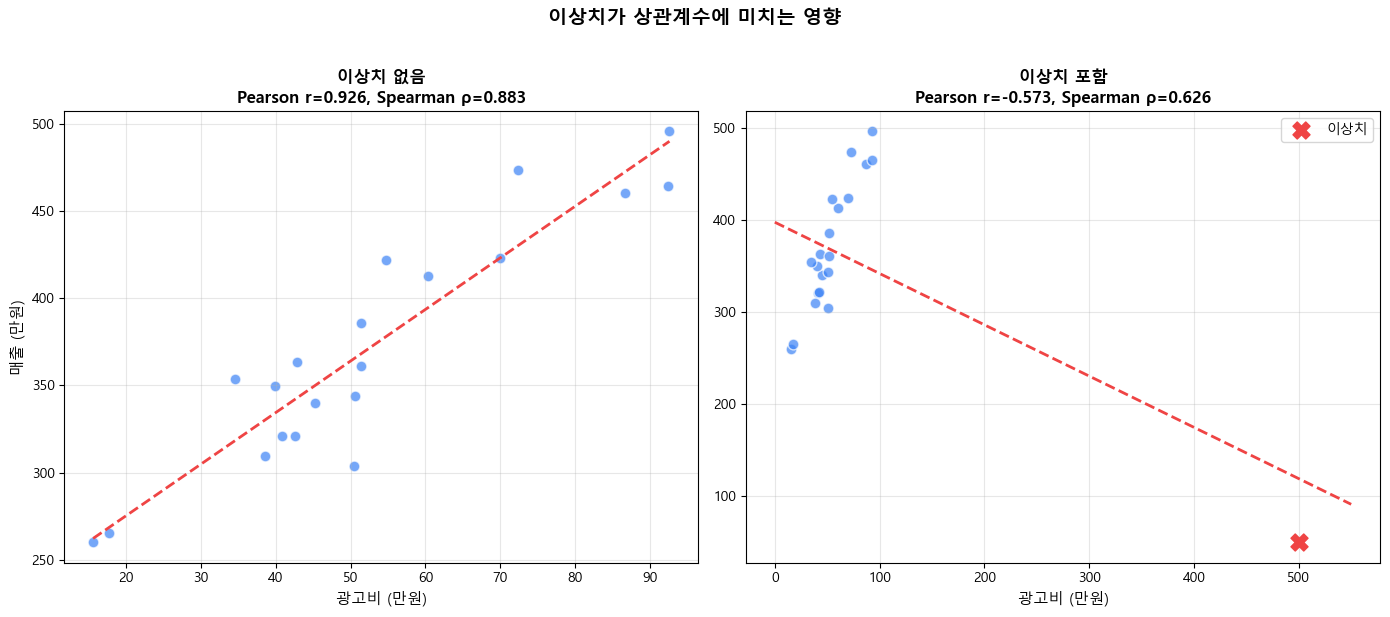


[핵심 포인트]
  Pearson은 이상치 하나에도 크게 영향을 받습니다
  이상치가 의심되면 Spearman을 함께 확인하세요
  상관계수만 보지 말고 반드시 산점도를 확인하세요


In [50]:
# ── 시각화: 이상치 영향 비교 ──
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 이상치 없이
axes[0].scatter(ad_cost, revenue, color='#3B82F6', alpha=0.7, s=60, edgecolors='white')
z1 = np.polyfit(ad_cost, revenue, 1)
x_line1 = np.linspace(ad_cost.min(), ad_cost.max(), 100)
axes[0].plot(x_line1, np.poly1d(z1)(x_line1), color='#EF4444', linewidth=2, linestyle='--')
axes[0].set_title(f'이상치 없음\nPearson r={r_p1_viz:.3f}, Spearman ρ={r_s1_viz:.3f}',
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel('광고비 (만원)', fontsize=11)
axes[0].set_ylabel('매출 (만원)', fontsize=11)
axes[0].grid(alpha=0.3)

# 이상치 포함
axes[1].scatter(ad_cost, revenue, color='#3B82F6', alpha=0.7, s=60, edgecolors='white')
axes[1].scatter(500, 50, color='#EF4444', s=150, marker='X', zorder=5, label='이상치')
z2 = np.polyfit(ad_cost_outlier, revenue_outlier, 1)
x_line2 = np.linspace(0, 550, 100)
axes[1].plot(x_line2, np.poly1d(z2)(x_line2), color='#EF4444', linewidth=2, linestyle='--')
axes[1].set_title(f'이상치 포함\nPearson r={r_p2_viz:.3f}, Spearman ρ={r_s2_viz:.3f}',
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel('광고비 (만원)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

fig.suptitle('이상치가 상관계수에 미치는 영향', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n[핵심 포인트]")
print("  Pearson은 이상치 하나에도 크게 영향을 받습니다")
print("  이상치가 의심되면 Spearman을 함께 확인하세요")
print("  상관계수만 보지 말고 반드시 산점도를 확인하세요")

### 시나리오 6: 상관 행렬과 히트맵 — 다변량 상관 분석

**상황**: 직원 데이터에서 여러 변수(경력, 급여, 만족도, 성과 점수) 간의 상관 관계를 종합적으로 분석합니다.

In [53]:
# ── 시나리오 6: 다변량 상관 분석 ──
print("\n[시나리오 6] 상관 행렬과 히트맵")
print("=" * 60)

np.random.seed(600)
n_emp = 50
experience = np.round(np.random.uniform(1, 20, n_emp), 1)
salary = np.round(3000 + 200 * experience + np.random.normal(0, 500, n_emp), 0)
satisfaction = np.round(np.clip(3 + 0.2 * experience + np.random.normal(0, 1.5, n_emp), 1, 10), 1)
performance = np.round(np.clip(50 + 1.5 * experience + 0.005 * salary + np.random.normal(0, 10, n_emp), 0, 100), 1)

df_emp = pd.DataFrame({
    '경력(년)': experience,
    '급여(만원)': salary,
    '만족도': satisfaction,
    '성과점수': performance
})

print("  기술통계:")
display(df_emp.describe().round(2))
display(df_emp.head())


[시나리오 6] 상관 행렬과 히트맵
  기술통계:


,경력(년),급여(만원),만족도,성과점수
count,50.00,50.00,50.00,50.00
mean,10.04,4941.54,5.02,86.05
std,5.99,1228.02,1.68,13.17
min,1.20,2212.00,1.00,56.80
25%,5.35,4052.00,3.75,75.12
50%,8.95,5087.00,5.15,85.95
75%,15.22,5705.00,6.18,100.00
max,19.80,7171.00,8.80,100.00


,경력(년),급여(만원),만족도,성과점수
0,1.6,3412.0,4.8,72.8
1,11.3,5397.0,3.1,93.4
2,16.3,6429.0,6.2,100.0
3,2.0,3542.0,1.4,79.3
4,8.3,5332.0,3.2,96.0


In [56]:
# ── 상관 행렬 계산 ──
# TODO: Pearson 상관 행렬 계산 
corr_matrix = df_emp.corr()

if corr_matrix is not None:
    print("\n[Pearson 상관 행렬]")
    display(corr_matrix.round(4))


corr_matrix = df_emp.corr(method='spearman')

if corr_matrix is not None:
    print("\n[spearman 상관 행렬]")
    display(corr_matrix.round(4))


[Pearson 상관 행렬]


,경력(년),급여(만원),만족도,성과점수
경력(년),1.0000,0.9167,0.5626,0.8456
급여(만원),0.9167,1.0000,0.4915,0.8738
만족도,0.5626,0.4915,1.0000,0.3969
성과점수,0.8456,0.8738,0.3969,1.0000



[spearman 상관 행렬]


,경력(년),급여(만원),만족도,성과점수
경력(년),1.0000,0.9225,0.5408,0.8677
급여(만원),0.9225,1.0000,0.5118,0.8891
만족도,0.5408,0.5118,1.0000,0.4216
성과점수,0.8677,0.8891,0.4216,1.0000


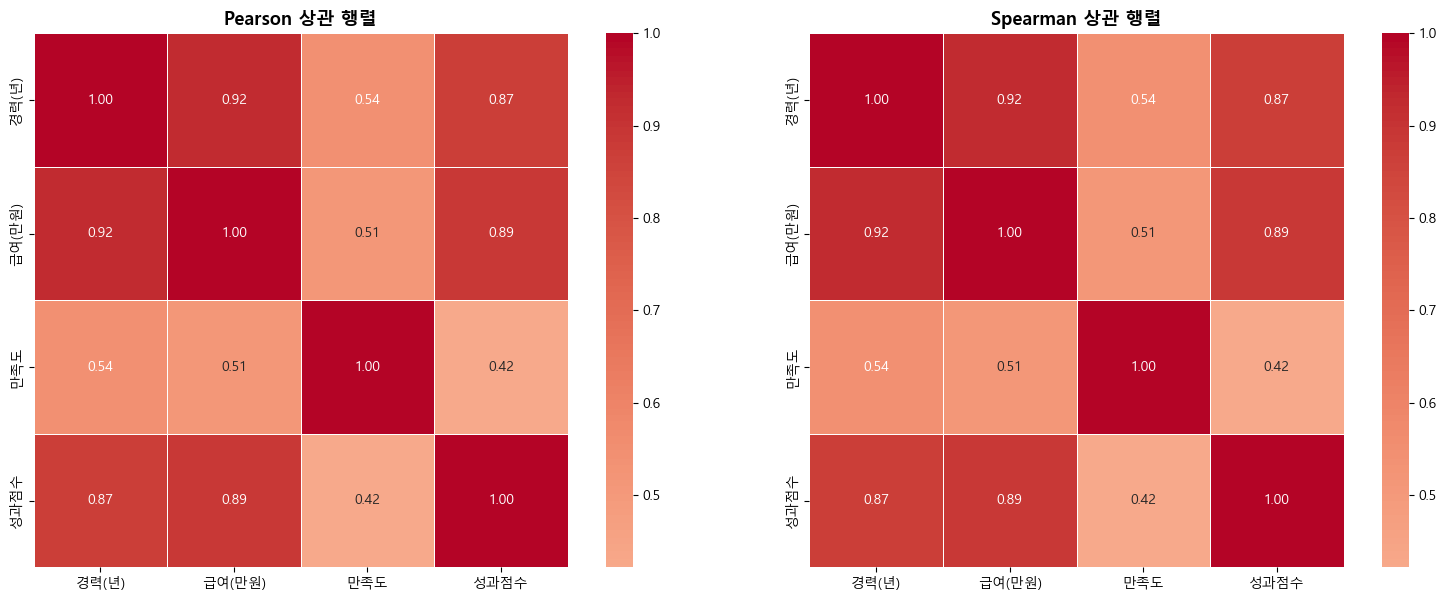

In [57]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, ax=axes[0])
axes[0].set_title('Pearson 상관 행렬', fontsize=13, fontweight='bold')

# Spearman
sns.heatmap(df_emp.corr(method='spearman'), annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True, linewidths=0.5, ax=axes[1])
axes[1].set_title('Spearman 상관 행렬', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

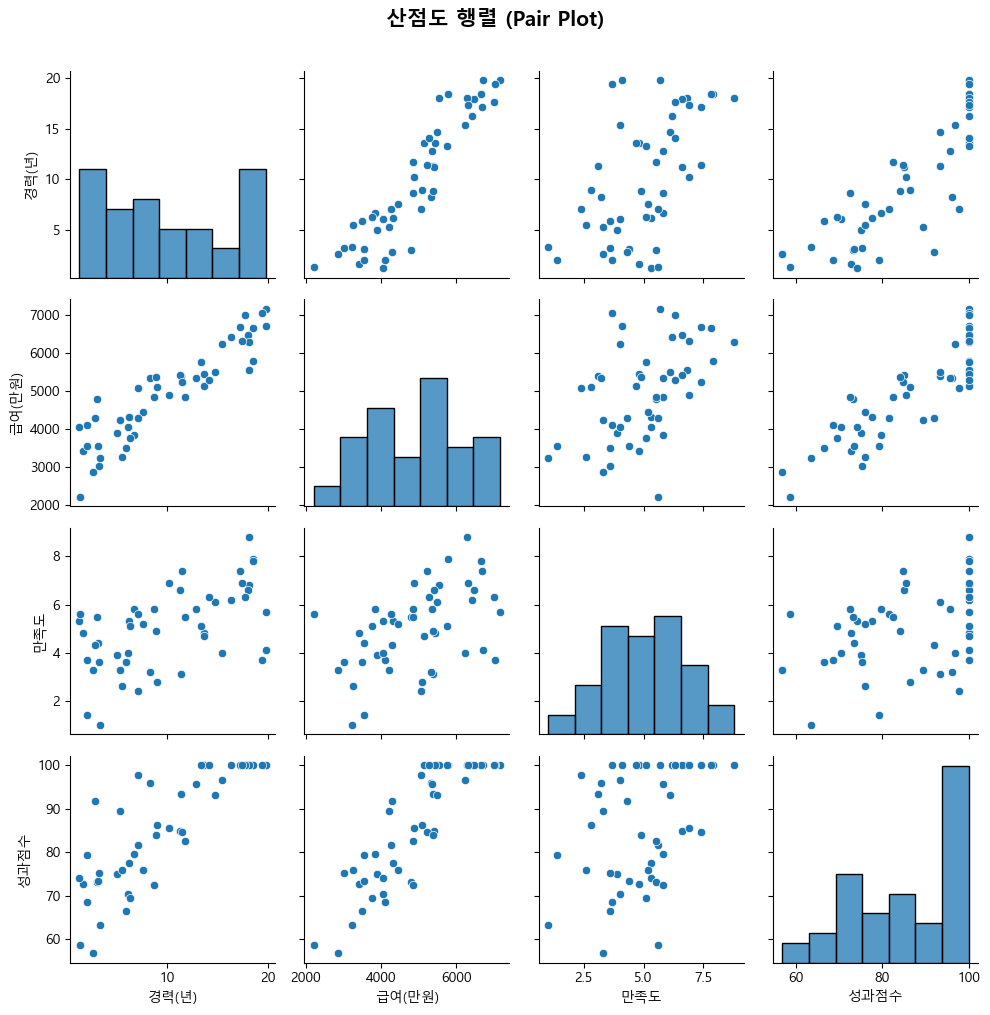

In [58]:
sns.pairplot(df_emp)
plt.suptitle('산점도 행렬 (Pair Plot)', fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

In [59]:
# ============================================================
# 1. Pearson 상관분석
# ============================================================
# TODO: pg 모듈로 Pearson 상관분석 수행
# 주요 컬럼: r(상관계수), CI95%(신뢰구간), p-unc(유의확률), BF10(베이즈 팩터), power(검정력)
pearson_result = pg.pairwise_corr(df_emp, method='pearson')

print("=" * 70)
print("[Pearson 상관분석 결과]")
print("  - 두 변수 간 '선형 관계'의 강도와 방향을 측정")
print("  - 정규분포를 따르는 연속형 변수에 적합")
print("=" * 70)
display(pearson_result)



# ============================================================
# 2. Spearman 상관분석
# ============================================================
# TODO: pg 모듈로 Spearman 상관분석 수행
spearman_result = pg.pairwise_corr(df_emp, method='spearman')

print("\n" + "=" * 70)
print("[Spearman 순위 상관분석 결과]")
print("  - 두 변수 간 '단조 관계'의 강도와 방향을 측정")
print("  - 순위 기반 → 정규성 가정 불필요 (비모수적 방법)")
print("  - 이상치에 강건하고, 순서형 데이터에도 사용 가능")
print("=" * 70)
display(spearman_result)


# ============================================================
# 3. Pearson vs Spearman 비교표
# ============================================================
# TODO: 두 결과를 비교하는 DataFrame 생성
# 비교 해석 가이드:
#   - Pearson ≈ Spearman  → 관계가 선형에 가까움
#   - Pearson < Spearman  → 비선형이지만 단조적 관계 존재
#   - Pearson > Spearman  → 이상치가 Pearson을 부풀렸을 가능성
print("\n" + "=" * 70)
print("[Pearson vs Spearman 비교]")
print("=" * 70)
comparison = pd.DataFrame({
    '변수쌍': pearson_result['X'] + ' ↔ ' + pearson_result['Y'],
    'Pearson_r': pearson_result['r'].round(4).values,
    'Spearman_ρ': spearman_result['r'].round(4).values,
    '차이(|P-S|)': abs(pearson_result['r'].values - spearman_result['r'].values).round(4)
})
display(comparison)


[Pearson 상관분석 결과]
  - 두 변수 간 '선형 관계'의 강도와 방향을 측정
  - 정규분포를 따르는 연속형 변수에 적합


,X,Y,method,alternative,n,r,CI95%,p-unc,BF10,power
0,경력(년),급여(만원),pearson,two-sided,50,0.916718,"[0.86, 0.95]",9.328239e-21,4.061e+17,1.000000
1,경력(년),만족도,pearson,two-sided,50,0.562579,"[0.34, 0.73]",2.116110e-05,1146.922,0.992677
2,경력(년),성과점수,pearson,two-sided,50,0.845584,"[0.74, 0.91]",1.107451e-14,6.514e+11,1.000000
3,급여(만원),만족도,pearson,two-sided,50,0.491546,"[0.25, 0.68]",2.889253e-04,104.284,0.960858
4,급여(만원),성과점수,pearson,two-sided,50,0.873777,"[0.79, 0.93]",1.223470e-16,4.766e+13,1.000000
5,만족도,성과점수,pearson,two-sided,50,0.396948,"[0.13, 0.61]",4.315337e-03,9.228,0.827576



[Spearman 순위 상관분석 결과]
  - 두 변수 간 '단조 관계'의 강도와 방향을 측정
  - 순위 기반 → 정규성 가정 불필요 (비모수적 방법)
  - 이상치에 강건하고, 순서형 데이터에도 사용 가능


,X,Y,method,alternative,n,r,CI95%,p-unc,power
0,경력(년),급여(만원),spearman,two-sided,50,0.922508,"[0.87, 0.96]",1.768403e-21,1.000000
1,경력(년),만족도,spearman,two-sided,50,0.540779,"[0.31, 0.71]",5.027224e-05,0.986946
2,경력(년),성과점수,spearman,two-sided,50,0.867709,"[0.78, 0.92]",3.516094e-16,1.000000
3,급여(만원),만족도,spearman,two-sided,50,0.511770,"[0.27, 0.69]",1.454832e-04,0.974259
4,급여(만원),성과점수,spearman,two-sided,50,0.889087,"[0.81, 0.94]",6.568565e-18,1.000000
5,만족도,성과점수,spearman,two-sided,50,0.421563,"[0.16, 0.63]",2.296093e-03,0.874737



[Pearson vs Spearman 비교]


,변수쌍,Pearson_r,Spearman_ρ,차이(|P-S|)
0,경력(년) ↔ 급여(만원),0.9167,0.9225,0.0058
1,경력(년) ↔ 만족도,0.5626,0.5408,0.0218
2,경력(년) ↔ 성과점수,0.8456,0.8677,0.0221
3,급여(만원) ↔ 만족도,0.4915,0.5118,0.0202
4,급여(만원) ↔ 성과점수,0.8738,0.8891,0.0153
5,만족도 ↔ 성과점수,0.3969,0.4216,0.0246


### 흔한 오해

| 오해 | 진실 |
|------|------|
| "r = 0이면 관계가 없다" | **선형** 관계가 없다는 뜻입니다. 비선형 관계(∪, ∩ 등)는 있을 수 있습니다 |
| "상관이 높으면 인과관계" | 상관은 **연관성**만 나타냅니다.|
| "Pearson이 항상 최선" | 이상치·비정규·서열척도에서는 Spearman이 더 적절합니다 |
| "r 값만 확인" | **r, p-value, 산점도(시각화)** 를 함께 제시해야 합니다. r=0.8이어도 산점도를 보면 이상치 때문일 수 있습니다 |

### 상관 vs 인과

| 구분 | 상관 (Correlation) | 인과 (Causation) |
|------|-------------------|------------------|
| 의미 | 두 변수가 **함께 움직이는** 정도 | A **때문에** B가 변하는 관계 |
| 방향 | A ↔ B (대칭) | A → B (비대칭) |
| 확인 방법 | 상관계수 + 검정 | 실험(RCT), 자연실험 등 |
| 예시 | 아이스크림 판매↑ ↔ 익사↑ | 광고 노출 → 전환율↑ (A/B 테스트) |

> **핵심**: "상관이 있다 ≠ 원인이다" \
> 아이스크림 판매와 익사 사고의 상관은 **여름(기온)** 이라는 교란변수 때문입니다. \
> 인과를 확인하려면 **실험(무작위 대조 실험, A/B 테스트)** 이 필요합니다.

---

## Part 3: A/B 테스트

### 3.1 주요 용어 정리

| 용어              | 영어                            | 정의                                                       |
|-------------------|---------------------------------|------------------------------------------------------------|
| A/B 테스트        | A/B Test                        | 두 가지(또는 그 이상) 버전을 비교하는 **무작위 대조 실험**  |
| 대조군            | Control Group                   | 기존 버전을 경험하는 집단                                   |
| 실험군            | Treatment Group                 | 새로운 버전을 경험하는 집단                                 |
| 무작위 배정       | Random Assignment               | 실험 참가자를 무작위로 대조군/실험군에 배정하는 과정         |
| 전환율            | Conversion Rate                 | 목표 행동(구매, 클릭 등)을 수행한 비율                      |
| 검정력            | Statistical Power (1−β)         | 실제 차이가 있을 때 이를 **탐지할 확률**                    |
| MDE               | Minimum Detectable Effect       | 주어진 검정력·유의수준 하에서 탐지 가능한 최소 효과 크기     |
| 1종 오류 (α)      | Type I Error (False Positive)   | 차이가 없는데 있다고 잘못 판단할 확률                       |
| 2종 오류 (β)      | Type II Error (False Negative)  | 차이가 있는데 없다고 놓칠 확률                              |

### 3.2 A/B 테스트의 원리

A/B 테스트는 **무작위 대조 실험** 의 실무 적용입니다.

**배경**: 넷플릭스에서 자동재생 미리보기 기능 도입 검토 중

1. **가설 수립**: "자동재생 시 시청 시작률이 올라갈 것이다"

2. **무작위 배정**: 사용자를 대조군(기존)과 실험군(변경)에 무작위 배정

3. **데이터 수집**: 충분한 기간 동안 지표(전환율 등) 수집

4. **통계 검정**: 두 집단 간 차이가 통계적으로 유의한지 판단

5. **의사결정**: 결과에 따라 변경 사항 적용 여부 결정

> **핵심**: 무작위 배정이 교란변수를 제거하므로, 관찰된 차이를 **인과적 효과**로 해석할 수 있습니다.

### 3.3 실험 설계 — 표본 크기 산정

A/B 테스트에서는 실험 **전에** 필요한 표본 크기를 산정합니다.

**필요한 입력값:**

| 항목 | 기호 | 일반적 설정 | 설명 |
|------|------|-------------|------|
| 유의수준 | α | 0.05 | 1종 오류 허용 확률 |
| 검정력 | 1−β | 0.80 | 실제 차이 탐지 확률 |
| MDE | δ | 비즈니스 결정 | 탐지하고 싶은 최소 효과 크기 |
| 기준 전환율 | p₀ | 현재 데이터 | 현재(대조군) 전환율 |

> **MDE가 작을수록** 더 많은 표본이 필요합니다. \
> **검정력이 높을수록** 더 많은 표본이 필요합니다.

<img src="images/pr_05/AB테스트_프로세스.png" width="100%">

### 시나리오 7: A/B 테스트 — 웹사이트 전환율 비교

**상황**: 한 온라인 쇼핑몰에서 결제 버튼 색상을 변경(녹색 → 주황색)하면

전환율이 달라지는지 A/B 테스트를 수행합니다.

- **대조군(A)**: 기존 녹색 버튼

- **실험군(B)**: 새로운 주황색 버튼

- **지표**: 전환율 (구매 완료 비율)

In [63]:
from statsmodels.stats.proportion import proportions_ztest, proportion_effectsize, proportion_confint
from statsmodels.stats.power import NormalIndPower

print("\n[시나리오 7] A/B 테스트 — 웹사이트 전환율 비교")
print("=" * 60)

# 실험 설계 파라미터
baseline_rate = 0.12   # 기존 전환율 12%
mde = 0.02             # 최소 탐지 효과 2%p (12% → 14%) 
alpha = 0.05           # 유의수준
power = 0.80           # 검정력

# TODO: 효과크기 계산 (Cohen's h)
effect_size = abs(proportion_effectsize(baseline_rate + mde, baseline_rate))

# TODO: 필요 표본 크기 산정
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    alternative='two-sided'
)

print(f"\n[1] 실험 설계 (양측검정)")
print("-" * 40)
print(f"  기존 전환율 (p₀): {baseline_rate:.0%}")
print(f"  목표 전환율 (p₁): {baseline_rate + mde:.0%}")
print(f"  MDE (최소 탐지 효과): {mde:.0%}p")
if effect_size is not None:
    print(f"  효과크기 (Cohen's h): {effect_size:.4f}")
if sample_size is not None:
    sample_size = int(np.ceil(sample_size))
    print(f"\n  집단당 필요 표본 크기: {sample_size:,}명")
    print(f"  총 필요 표본 크기: {sample_size * 2:,}명")


[시나리오 7] A/B 테스트 — 웹사이트 전환율 비교

[1] 실험 설계 (양측검정)
----------------------------------------
  기존 전환율 (p₀): 12%
  목표 전환율 (p₁): 14%
  MDE (최소 탐지 효과): 2%p
  효과크기 (Cohen's h): 0.0595

  집단당 필요 표본 크기: 4,433명
  총 필요 표본 크기: 8,866명


**상황**: 한 온라인 쇼핑몰에서 결제 버튼 색상을 주황색으로 변경하면
전환율이 **기존보다 높아지는지** A/B 테스트를 수행합니다.

- **대조군(A)**: 기존 녹색 버튼
- **실험군(B)**: 새로운 주황색 버튼

In [ ]:
# 실험 설계 파라미터
baseline_rate = 0.12   # 기존 전환율 12%
mde = 0.02             # 최소 탐지 효과 2%p (12% → 14%)
alpha = 0.05           # 유의수준
power = 0.80           # 검정력

# TODO: 효과크기 계산 (Cohen's h) — 양측과 동일
effect_size =  abs(proportion_effectsize(baseline_rate + mde, baseline_rate))

# TODO: 필요 표본 크기 산정 
power_analysis = NormalIndPower()
sample_size = power_analysis.solve_power(
    effect_size=effect_size,
    alpha=alpha,
    power=power,
    alternative='larger'
)
sample_size = int(np.ceil(sample_size))

print(f"\n[1] 실험 설계 (단측검정)")
print("-" * 40)
print(f"  기존 전환율 (p₀): {baseline_rate:.0%}")
print(f"  목표 전환율 (p₁): {baseline_rate + mde:.0%}")
print(f"  MDE (최소 탐지 효과): {mde:.0%}p")
if effect_size is not None:
    print(f"  효과크기 (Cohen's h): {effect_size:.4f}")
if sample_size is not None:
    sample_size = int(np.ceil(sample_size))
    print(f"\n  집단당 필요 표본 크기: {sample_size:,}명")
    print(f"  총 필요 표본 크기: {sample_size * 2:,}명")

# 단측더 필요하나? 양측이더 필요하나? ->> 양측이더 필요!!


[1] 실험 설계 (단측검정)
----------------------------------------
  기존 전환율 (p₀): 12%
  목표 전환율 (p₁): 14%
  MDE (최소 탐지 효과): 2%p
  효과크기 (Cohen's h): 0.0595

  집단당 필요 표본 크기: 3,492명
  총 필요 표본 크기: 6,984명


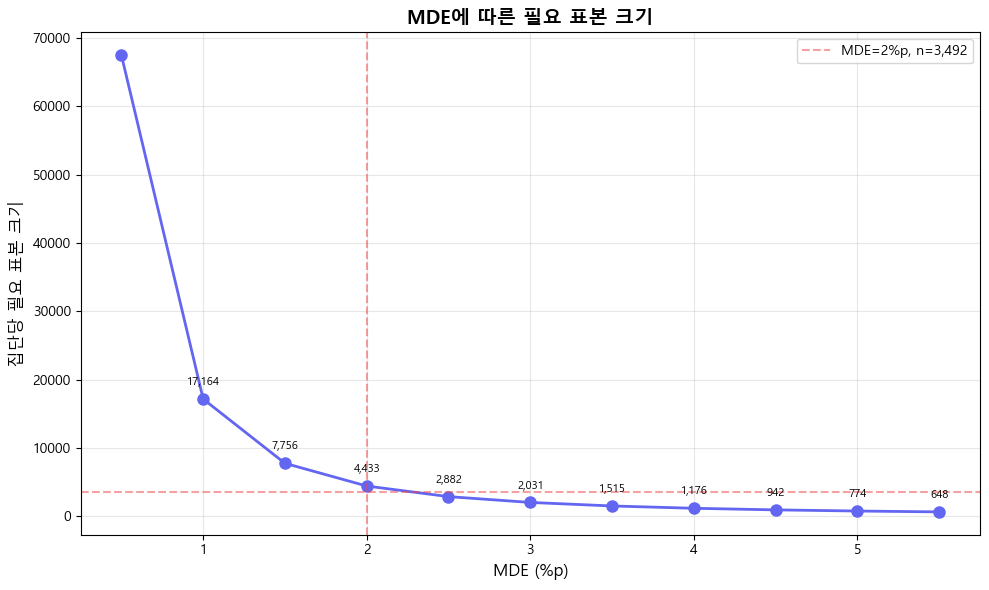


  * MDE가 작을수록 더 많은 표본이 필요합니다
  * 비즈니스적으로 의미 있는 최소 효과를 기준으로 MDE를 설정합니다


In [65]:
mde_range = np.arange(0.005, 0.06, 0.005)
sample_sizes = []

for m in mde_range:
    es = proportion_effectsize(baseline_rate, baseline_rate + m)
    n = power_analysis.solve_power(effect_size=es, alpha=alpha, power=power,
                                   alternative='two-sided')
    sample_sizes.append(int(np.ceil(n)))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(mde_range * 100, sample_sizes, 'o-', color='#6366F1', linewidth=2, markersize=8)
sample_size_viz = sample_size if sample_size is not None else 0
if sample_size is not None:
    ax.axhline(y=sample_size, color='#EF4444', linestyle='--', alpha=0.5,
               label=f'MDE={mde*100:.0f}%p, n={sample_size:,}')
    ax.axvline(x=mde * 100, color='#EF4444', linestyle='--', alpha=0.5)

ax.set_xlabel('MDE (%p)', fontsize=12)
ax.set_ylabel('집단당 필요 표본 크기', fontsize=12)
ax.set_title('MDE에 따른 필요 표본 크기', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# 포인트별 표본 크기 표시
for m, n in zip(mde_range, sample_sizes):
    if n < 20000:
        ax.annotate(f'{n:,}', (m * 100, n), textcoords="offset points",
                    xytext=(0, 10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n  * MDE가 작을수록 더 많은 표본이 필요합니다")
print("  * 비즈니스적으로 의미 있는 최소 효과를 기준으로 MDE를 설정합니다")

In [66]:
# ── 시나리오 7: A/B 테스트 실행 (시뮬레이션) ──
print(f"\n[2] A/B 테스트 실행")
print("=" * 60)

np.random.seed(700)
n_per_group = sample_size if sample_size is not None else 2000  # fallback

# 데이터 생성 (실험군이 약간 더 높은 전환율)
control_conversions = np.random.binomial(1, 0.12, n_per_group)  # 대조군: 12%
treatment_conversions = np.random.binomial(1, 0.145, n_per_group)  # 실험군: 14.5%

#  각 집단의 전환율 계산
control_rate = control_conversions.mean()
treatment_rate = treatment_conversions.mean()

if control_rate is not None and treatment_rate is not None:
    print(f"  대조군 (녹색 버튼): {control_conversions.sum():,}/{n_per_group:,} = {control_rate:.4f} ({control_rate:.2%})")
    print(f"  실험군 (주황 버튼): {treatment_conversions.sum():,}/{n_per_group:,} = {treatment_rate:.4f} ({treatment_rate:.2%})")
    print(f"  차이: {treatment_rate - control_rate:.4f} ({(treatment_rate - control_rate):.2%}p)")


[2] A/B 테스트 실행
  대조군 (녹색 버튼): 407/3,492 = 0.1166 (11.66%)
  실험군 (주황 버튼): 510/3,492 = 0.1460 (14.60%)
  차이: 0.0295 (2.95%p)


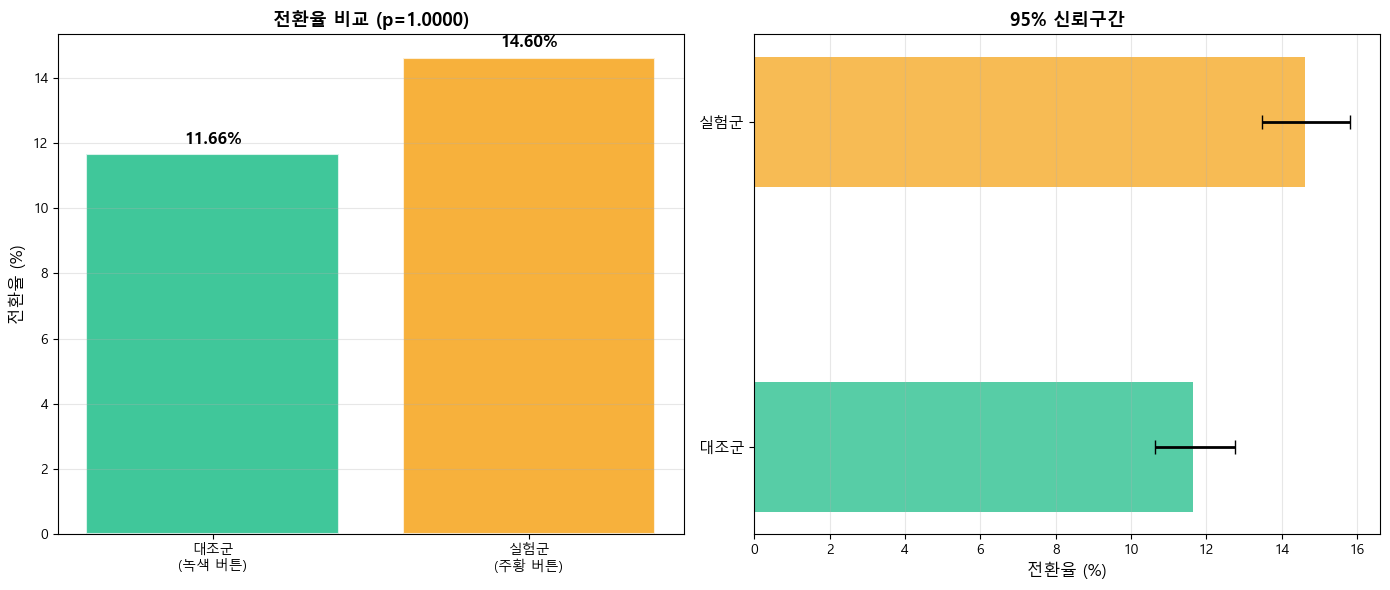

In [67]:
# ── 전환율 비교 시각화 ──
control_rate_viz = control_rate if control_rate is not None else 0
treatment_rate_viz = treatment_rate if treatment_rate is not None else 0
z_p_viz = z_p if 'z_p' in dir() and z_p is not None else 1.0

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 막대 그래프
rates = [control_rate_viz * 100, treatment_rate_viz * 100]
bar_colors = ['#10B981', '#F59E0B']
bars = axes[0].bar(['대조군\n(녹색 버튼)', '실험군\n(주황 버튼)'], rates,
                    color=bar_colors, alpha=0.8, edgecolor='white', linewidth=1.5)

for bar, rate in zip(bars, rates):
    axes[0].text(bar.get_x() + bar.get_width()/2., rate + 0.2,
                 f'{rate:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

axes[0].set_ylabel('전환율 (%)', fontsize=12)
axes[0].set_title(f'전환율 비교 (p={z_p_viz:.4f})', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# TODO : 신뢰구간 시각화
# 각 집단 전환율의 95% 신뢰구간 (Wilson score 방법: 소표본에서도 안정적)
ci_c = proportion_confint(control_conversions.sum(), n_per_group, alpha=0.05, method='wilson') # 대조군
ci_t = proportion_confint(treatment_conversions.sum(), n_per_group, alpha=0.05, method='wilson') # 실험군

y_pos = [0, 1]
axes[1].barh(y_pos, [control_rate_viz * 100, treatment_rate_viz * 100],
             color=bar_colors, alpha=0.7, height=0.4)
axes[1].errorbar([control_rate_viz * 100, treatment_rate_viz * 100], y_pos,
                 xerr=[[control_rate_viz * 100 - ci_c[0] * 100, treatment_rate_viz * 100 - ci_t[0] * 100],
                        [ci_c[1] * 100 - control_rate_viz * 100, ci_t[1] * 100 - treatment_rate_viz * 100]],
                 fmt='none', color='black', capsize=5, linewidth=2)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(['대조군', '실험군'], fontsize=11)
axes[1].set_xlabel('전환율 (%)', fontsize=12)
axes[1].set_title('95% 신뢰구간', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#### z-비율검정의 전제 조건

z-검정은 이항분포를 정규분포로 근사하므로, 각 그룹에서 아래 조건을 만족해야 합니다.

> **n·p ≥ 5 이고 n·(1-p) ≥ 5**

A/B 테스트는 보통 수천~수만 명의 표본을 확보하므로 이 조건을 쉽게 충족하며, **z-비율검정이 표준적으로 사용**됩니다.

만약 표본이 작거나 전환율이 극단적(0.1% 등)이어서 조건을 충족하지 못하면 대안 검정을 사용합니다:

| 상황 | 대안 | 비고 |
|------|------|------|
| 실무 (소표본) | **카이제곱 검정** | 계산이 빠르고 실무에서 통용 |
| 연구/논문 (소표본) | **Fisher 정확검정** | 근사 없이 정확한 p-value 산출, 리뷰어 신뢰도 확보 |

> *표본이 충분히 크면 세 검정 모두 결과가 거의 동일합니다. 차이는 **정확성 vs 속도**의 트레이드오프입니다.*

In [71]:
count, nobs

(array([510, 407]), array([3492, 3492]))

In [74]:
from statsmodels.stats.proportion import confint_proportions_2indep

print(f"\n[3] 두 비율의 z-검정")
print("=" * 60)

count = np.array([treatment_conversions.sum(), control_conversions.sum()])
nobs = np.array([n_per_group, n_per_group])

# TODO: 두 비율의 z-검정 수행 (proportions_ztest)
z_stat, z_p = proportions_ztest(count, nobs, alternative='larger') #각집단별 전환수, 각집단별 표본 개수

print(f"  z 통계량: {z_stat:.4f}")
print(f"  p-value: {z_p:.4f}")

# 가설 판정
verdict_ab = 'H₀ 기각: 버튼 색상 변경이 전환율에 유의한 영향을 줍니다' if z_p < 0.05 else 'H₀ 기각 실패: 유의한 차이가 없습니다'
print(f"  판정: {verdict_ab}")

# TODO: 비율 차이의 95% 신뢰구간
ci_low, ci_upp = confint_proportions_2indep(
    count[0], nobs[0],   # treatment: 성공 수, 표본 크기
    count[1], nobs[1],   # control: 성공 수, 표본 크기
    method='wald'        # method: 'wald'(정규근사, 대표본), 'newcombe'(Wilson 기반, 소표본 디폴트 값),
)

diff = treatment_rate - control_rate
print(f"\n  비율 차이: {diff:.4f}")
print(f"  95% 신뢰구간: [{ci_low:.4f}, {ci_upp:.4f}]")

# TODO: 효과크기 Cohen's h 계산 (proportion_effectsize)
h = proportion_effectsize(control_rate, treatment_rate)
size_h = '매우 작은' if abs(h) < 0.2 else '작은' if abs(h) < 0.5 else '중간' if abs(h) < 0.8 else '큰'
print(f"\n  [효과크기] Cohen's h = {abs(h):.4f} ({size_h} 효과)")


size_h = '매우 작은' if abs(h) < 0.2 else '작은' if abs(h) < 0.5 else '중간' if abs(h) < 0.8 else '큰'
print(f"\n  [효과크기] Cohen's h = {abs(h):.4f} ({size_h} 효과)")

# # TODO: 상대적 개선율

relative_lift = (treatment_rate - control_rate) / control_rate * 100
print(f"  상대적 개선율: {relative_lift:+.1f}%") # 상대적 개선율: +25.3%
# 효과크기는 작은데, 상대적 개선율을 높아보이는 이유?


[3] 두 비율의 z-검정
  z 통계량: 3.6494
  p-value: 0.0001
  판정: H₀ 기각: 버튼 색상 변경이 전환율에 유의한 영향을 줍니다

  비율 차이: 0.0295
  95% 신뢰구간: [0.0137, 0.0453]

  [효과크기] Cohen's h = 0.0875 (매우 작은 효과)

  [효과크기] Cohen's h = 0.0875 (매우 작은 효과)
  상대적 개선율: +25.3%


### 시나리오 8: A/B 테스트 — 연속형 지표 비교 (평균 체류시간)

**상황**: 웹사이트의 새로운 레이아웃(B)이 기존 레이아웃(A) 대비 평균 페이지 체류시간을 늘리는지 검정합니다. 
- 연속형 지표이므로 t-검정을 사용합니다.

In [75]:
# ── 시나리오 9: 연속형 지표 A/B 테스트 ──
print("\n[시나리오 9] A/B 테스트 — 평균 체류시간 비교")
print("=" * 60)

np.random.seed(900)
n_ab = 500

# 데이터 생성
time_control = np.round(np.random.exponential(scale=120, size=n_ab), 1)   # 대조군: 평균 120초
time_treatment = np.round(np.random.exponential(scale=135, size=n_ab), 1) # 실험군: 평균 135초

print(f"  대조군 (기존 레이아웃): 평균={time_control.mean():.1f}초, 중앙값={np.median(time_control):.1f}초")
print(f"  실험군 (새 레이아웃): 평균={time_treatment.mean():.1f}초, 중앙값={np.median(time_treatment):.1f}초")

# 정규성 확인
print(f"\n[1] Shapiro-Wilk 정규성 검정")
print("-" * 40)
# 표본 크기가 크므로 부분 표본으로 검정
for name, data in [('대조군', time_control), ('실험군', time_treatment)]:
    # TODO: Shapiro-Wilk 정규성 검정 수행 (stats.shapiro)
    stat_sw, p_sw = None, None  # stats.shapiro(data)
    if stat_sw is not None:
        print(f"  {name}: W={stat_sw:.4f}, p={p_sw:.4f}")

print("  * 체류시간은 지수분포를 따르므로 정규성을 위반합니다")
print("  * 대표본(n=500)이므로 CLT에 의해 t-검정을 사용할 수 있습니다")
print("  * 비모수 검정(Mann-Whitney U)도 함께 비교합니다")


[시나리오 9] A/B 테스트 — 평균 체류시간 비교
  대조군 (기존 레이아웃): 평균=107.7초, 중앙값=68.1초
  실험군 (새 레이아웃): 평균=143.6초, 중앙값=99.5초

[1] Shapiro-Wilk 정규성 검정
----------------------------------------
  * 체류시간은 지수분포를 따르므로 정규성을 위반합니다
  * 대표본(n=500)이므로 CLT에 의해 t-검정을 사용할 수 있습니다
  * 비모수 검정(Mann-Whitney U)도 함께 비교합니다


In [76]:
# ── Welch's t-검정 (연속형 A/B 테스트) ──
# - 두 독립 집단의 평균 비교 (등분산 가정 불필요)
# - 연속형 지표(체류시간, 매출액 등)의 A/B 테스트에 사용
# 참고: pingouin은 검정 + 효과크기 + 검정력을 한 번에 제공

print(f"\n[2] 연속형 A/B 테스트 (체류시간 비교)")
print("=" * 60)

# ── 모수 검정: Welch's t-검정 (pingouin) ──
# - 두 독립 집단의 평균 비교 (등분산 가정 불필요)
# T        : t 통계량 (클수록 두 집단 차이가 큼)
# dof      : 자유도 (Welch 보정 적용)
# p-val    : 유의확률 (0.05 미만이면 유의한 차이)
# CI95%    : 평균 차이의 95% 신뢰구간
# cohen-d  : 효과크기 (<0.2 매우작은, <0.5 작은, <0.8 중간, ≥0.8 큰)
# BF10     : 베이즈 팩터 (>10 강한증거, >100 매우 강한증거)
# power    : 검정력 (1에 가까울수록 효과 탐지 확률 높음)
print("[모수 검정] Welch's t-검정")

# TODO: Welch's t-검정 수행 (pg.ttest)
ttest_result = pg.ttest(time_treatment, time_control, alternative='two-sided')
display(ttest_result)


# ── 비모수 검정: Mann-Whitney U (pingouin) ──
# - 정규성을 가정하지 않는 순위 기반 검정, 이상치에 강건
# U-val : U 통계량 (순위 합 기반)
# p-val : 유의확률
# RBC   : rank-biserial correlation, 효과크기 (<0.1 매우작은, <0.3 작은, <0.5 중간, ≥0.5 큰)
# CLES  : 실험군 1명이 대조군 1명보다 클 확률 (0.5=차이없음, 1.0=항상큼)
print("[비모수 검정] Mann-Whitney U")

# TODO: Mann-Whitney U 검정 수행 (pg.mwu)
mwu_result = pg.mwu(time_treatment, time_control, alternative='two-sided')
display(mwu_result)


# ── 판정 ──
# - Cohen's d: 개인 간 변동(분산) 대비 평균 차이 → 분산이 크면 작게 나옴
# - 상대적 개선율: 기존 평균 대비 몇 % 개선 → 비즈니스 임팩트 전달용
# - 둘 다 함께 보고해야 균형 잡힌 해석 가능
t_p_ab = ttest_result['p-val'].values[0]
verdict_ab2 = '유의한 차이 있음' if t_p_ab < 0.05 else '유의한 차이 없음'
print(f"\n  판정: {verdict_ab2}")
if time_treatment.mean() > time_control.mean() and t_p_ab < 0.05:
    lift = (time_treatment.mean() - time_control.mean()) / time_control.mean() * 100
    print(f"  체류시간 개선: {time_treatment.mean() - time_control.mean():.1f}초 ({lift:+.1f}%)")


[2] 연속형 A/B 테스트 (체류시간 비교)
[모수 검정] Welch's t-검정


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.456831,998,two-sided,0.000009,"[20.08, 51.67]",0.281875,1156.785,0.993659


[비모수 검정] Mann-Whitney U


,U-val,alternative,p-val,RBC,CLES
MWU,145778.5,two-sided,0.000005,0.166228,0.583114



  판정: 유의한 차이 있음
  체류시간 개선: 35.9초 (+33.3%)


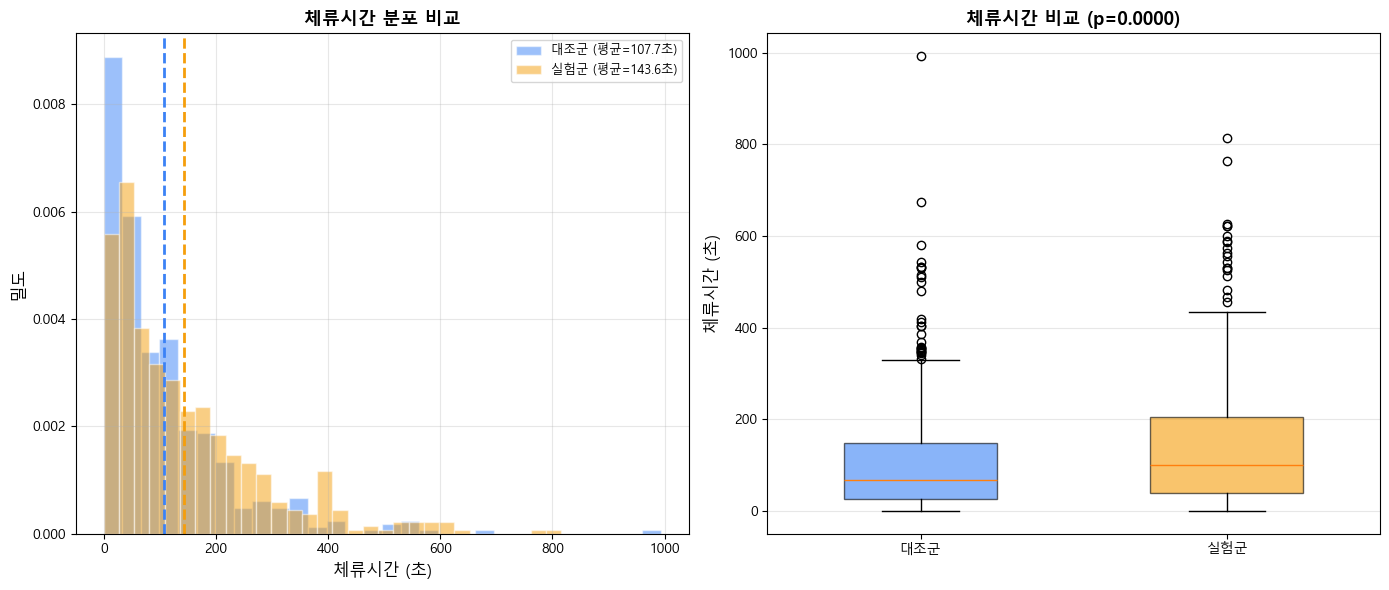

In [77]:
# ── 분포 비교 시각화 ──
t_p_ab_viz = t_p_ab if t_p_ab is not None else 1.0

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 히스토그램
axes[0].hist(time_control, bins=30, alpha=0.5, color='#3B82F6', edgecolor='white',
             label=f'대조군 (평균={time_control.mean():.1f}초)', density=True)
axes[0].hist(time_treatment, bins=30, alpha=0.5, color='#F59E0B', edgecolor='white',
             label=f'실험군 (평균={time_treatment.mean():.1f}초)', density=True)
axes[0].axvline(time_control.mean(), color='#3B82F6', linestyle='--', linewidth=2)
axes[0].axvline(time_treatment.mean(), color='#F59E0B', linestyle='--', linewidth=2)
axes[0].set_xlabel('체류시간 (초)', fontsize=12)
axes[0].set_ylabel('밀도', fontsize=12)
axes[0].set_title('체류시간 분포 비교', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# 박스플롯
bp = axes[1].boxplot([time_control, time_treatment],
                      labels=['대조군', '실험군'],
                      patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3B82F6')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('#F59E0B')
bp['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel('체류시간 (초)', fontsize=12)
axes[1].set_title(f'체류시간 비교 (p={t_p_ab_viz:.4f})', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 흔한 오해

| 오해 | 진실 |
|------|------|
| "A/B 테스트는 p < 0.05면 성공" | p-value만으로 판단하면 안 됩니다. 효과크기와 비즈니스 의미도 함께 고려해야 합니다 |
| "표본이 많을수록 무조건 좋다" | 불필요하게 큰 표본은 비용 낭비입니다. 검정력 분석으로 적절한 표본 크기를 산정합니다 |
| "A/B 테스트 도중 결과를 확인해도 된다" | 중간에 결과를 보고 중단하면(**peeking**) 1종 오류가 증가합니다. 사전에 정한 표본 크기를 채워야 합니다 |
| "전후 비교 = A/B 테스트" | 전후 비교는 시간 효과를 통제하지 못합니다. **동시에 무작위 배정**해야 A/B 테스트입니다 |

## 5회차 핵심 함수 정리

### 가정 검정 (정규성, 등분산성)

| 함수/메서드 | 용도 | 사용 예시 |
|------------|------|----------|
| `stats.shapiro(data)` | Shapiro-Wilk 정규성 검정 | stat, p = stats.shapiro(data) |
| `stats.probplot(data, dist, plot)` | Q-Q plot (정규성 시각화) | stats.probplot(data, dist='norm', plot=ax) |
| `stats.levene(a, b, c)` | Levene 등분산 검정 | stat, p = stats.levene(g1, g2, g3) |

### 분산분석 (ANOVA)

| 함수/메서드 | 용도 | 사용 예시 |
|------------|------|----------|
| `stats.f_oneway(a, b, c)` | One-way ANOVA (기본) | F, p = stats.f_oneway(g1, g2, g3) |
| `pg.anova(dv, between, data)` | One-way ANOVA (상세) | aov = pg.anova(dv='y', between='g', data=df, detailed=True) |
| `pg.welch_anova(dv, between, data)` | Welch's ANOVA (등분산 위반 시) | welch = pg.welch_anova(dv='y', between='g', data=df) |
| `stats.kruskal(a, b, c)` | Kruskal-Wallis (비모수) | H, p = stats.kruskal(g1, g2, g3) |

### 사후검정 (Post-hoc Tests)

| 함수/메서드 | 용도 | 사용 예시 |
|------------|------|----------|
| `pairwise_tukeyhsd(values, groups)` | Tukey HSD (One-way ANOVA 후) | tukey = pairwise_tukeyhsd(df['y'], df['g']) |
| `pg.pairwise_gameshowell(dv, between, data)` | Games-Howell (Welch's ANOVA 후) | gh = pg.pairwise_gameshowell(dv='y', between='g', data=df) |
| `sp.posthoc_dunn(df, val_col, group_col)` | Dunn (Kruskal-Wallis 후) | dunn = sp.posthoc_dunn(df, 'y', 'g', p_adjust='bonferroni') |

### 상관분석 (Correlation)

| 함수/메서드 | 용도 | 사용 예시 |
|------------|------|----------|
| `stats.pearsonr(x, y)` | 피어슨 상관계수 (선형) | r, p = stats.pearsonr(x, y) |
| `stats.spearmanr(x, y)` | 스피어만 상관계수 (순위) | rho, p = stats.spearmanr(x, y) |
| `df.corr(method)` | 상관 행렬 계산 | corr = df.corr(method='pearson') |
| `pg.pairwise_corr(df, method)` | 변수 쌍별 상관분석 (p값 포함) | result = pg.pairwise_corr(df, method='pearson') |

### A/B 테스트 & 비율 검정

| 함수/메서드 | 용도 | 사용 예시 |
|------------|------|----------|
| `proportions_ztest(count, nobs)` | 두 비율 Z 검정 | z, p = proportions_ztest([c1, c2], [n1, n2]) |
| `proportion_effectsize(p1, p2)` | 비율 효과크기 (Cohen's h) | h = proportion_effectsize(0.1, 0.15) |
| `proportion_confint(count, nobs)` | 비율 신뢰구간 | ci = proportion_confint(100, 1000, method='wilson') |
| `confint_proportions_2indep(c1, n1, c2, n2)` | 두 비율 차이의 신뢰구간 | ci_low, ci_upp = confint_proportions_2indep(c1, n1, c2, n2, method='wald') |
| `NormalIndPower().solve_power(...)` | 표본 크기/검정력 산정 | n = power.solve_power(effect_size=0.5, alpha=0.05, power=0.8) |

### 효과크기 & 추가 검정 함수

| 함수/메서드 | 용도 | 사용 예시 |
|------------|------|----------|
| `pg.compute_effsize(x, y, eftype)` | Cohen's d / Hedges' g | d = pg.compute_effsize(x, y, eftype='cohen') |
| `pg.ttest(x, y, alternative)` | pingouin t-검정 (상세) | result = pg.ttest(x, y, alternative='two-sided') |
| `pg.mwu(x, y, alternative)` | Mann-Whitney U 검정 | result = pg.mwu(x, y, alternative='two-sided') |

---

## 실습 완료

5회차에서 다룬 내용을 정리합니다.

| 문제     | 주제                                       | 핵심 학습 포인트                              |
|----------|--------------------------------------------|-----------------------------------------------|
| 문제 1   | 3개 공장의 배터리 수명 비교 (ANOVA)        | 가정 검정 → 검정 선택 → 사후검정 → 효과크기   |
| 문제 2   | 직원 데이터 상관분석                       | Pearson vs Spearman, 산점도, 상관 vs 인과      |
| 문제 3   | 앱 UI 변경 A/B 테스트 (전환율)             | 실험 설계 → 표본 크기 산정 → 검정 → 의사결정   |
| 문제 4   | 학습 앱 A/B 테스트 (연속형 지표)           | 연속형 A/B 테스트, CLT, 모수 vs 비모수         |

> **과제**는 `practice_05_assignment.ipynb` 파일을 확인해 주세요.